# Montecarlo Approximator

##  1. Importing Libraries

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [25]:
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict
from typing import List
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gym
import src.serializer as serializer
import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

##  2. Auxiliary functions

### 2.1 Print Result

In [4]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [5]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

###  2.2 Reduce State

In [6]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

### 2.3 Saving and Load History

In [7]:
def saveHistory(config,scores,total_rewards):
    base="history/"
    with open(base+"scores_"+config+".pickle", 'wb') as handle:
        pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(base+"total_rewards_"+config+".pickle", 'wb') as handle:
        pickle.dump(total_rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Scores and Total rewards for "+config+" saved")
    
def loadHistory(fileDir):
    with open(fileDir, 'rb') as handle:
        data = pickle.load(handle)
        return data

###  2.4 Reward Policy

In [8]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

In [ ]:
def get_Reward(typeR):
    

## 3. Running algorithms

### 3.1 Setting Parameters

In [9]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 50
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = -0.1

## 3.2 Montecarlo approximator

### 3.2.1 All features + StandarScaler

In [10]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False,feat_type: str="all"):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.updating(epi,feat_type)

In [11]:
env, initial_state = environment.get_env()

In [12]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=4,scaler=StandardScaler(),typeScale= "mean")

In [13]:
agent.trainScaler(env,RAM_mask,feat_type='mean')

In [14]:
scores = []
total_rewards = []

In [15]:
%%time

n_runs = 5000

for i in tqdm(range(n_runs)):
    render = i % 201 == 200

    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render,feat_type="mean")

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)
    """
    if i % 500 == 0:
      exp = serializer.Experiment(ql_agent_app, scores, total_rewards, reduce_state, reward_policy)
      exp.save_experiment(modelSavePath,'model_ql_approximator_'+str(i))
      print("Model saved!")
    """

  0%|          | 1/5000 [00:03<5:01:16,  3.62s/it]

Run [   0] - Total reward:  391.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 


  0%|          | 11/5000 [00:37<4:41:59,  3.39s/it]

Run [  10] - Total reward:  407.70 Mean scores: 11.18 Means Scores[:-10]: 11.10 Score: 12 


  0%|          | 21/5000 [01:10<4:31:41,  3.27s/it]

Run [  20] - Total reward:  465.00 Mean scores: 11.86 Means Scores[:-10]: 12.60 Score: 13 


  1%|          | 31/5000 [01:42<4:21:27,  3.16s/it]

Run [  30] - Total reward:  419.00 Mean scores: 12.13 Means Scores[:-10]: 12.70 Score: 12 


  1%|          | 41/5000 [02:13<4:13:12,  3.06s/it]

Run [  40] - Total reward:  409.30 Mean scores: 12.32 Means Scores[:-10]: 12.90 Score: 12 


  1%|          | 51/5000 [02:43<4:05:53,  2.98s/it]

Run [  50] - Total reward:  407.80 Mean scores: 12.53 Means Scores[:-10]: 13.40 Score: 12 


  1%|          | 61/5000 [03:13<4:04:50,  2.97s/it]

Run [  60] - Total reward:  468.20 Mean scores: 12.61 Means Scores[:-10]: 13.00 Score: 13 


  1%|▏         | 71/5000 [03:43<4:01:48,  2.94s/it]

Run [  70] - Total reward:  519.50 Mean scores: 12.86 Means Scores[:-10]: 14.40 Score: 14 


  2%|▏         | 81/5000 [04:12<3:58:45,  2.91s/it]

Run [  80] - Total reward:  394.00 Mean scores: 12.88 Means Scores[:-10]: 13.00 Score: 12 


  2%|▏         | 91/5000 [04:41<3:58:39,  2.92s/it]

Run [  90] - Total reward:  534.70 Mean scores: 12.95 Means Scores[:-10]: 13.50 Score: 14 


  2%|▏         | 101/5000 [05:10<3:56:52,  2.90s/it]

Run [ 100] - Total reward:  538.60 Mean scores: 13.05 Means Scores[:-10]: 14.00 Score: 14 


  2%|▏         | 111/5000 [05:39<3:53:09,  2.86s/it]

Run [ 110] - Total reward:  472.10 Mean scores: 13.10 Means Scores[:-10]: 13.60 Score: 13 


  2%|▏         | 121/5000 [06:07<3:53:34,  2.87s/it]

Run [ 120] - Total reward:  474.70 Mean scores: 13.15 Means Scores[:-10]: 13.70 Score: 13 


  3%|▎         | 131/5000 [06:37<4:08:14,  3.06s/it]

Run [ 130] - Total reward:  630.80 Mean scores: 13.27 Means Scores[:-10]: 14.70 Score: 16 


  3%|▎         | 141/5000 [07:07<3:49:06,  2.83s/it]

Run [ 140] - Total reward:  373.80 Mean scores: 13.31 Means Scores[:-10]: 13.90 Score: 11 


  3%|▎         | 151/5000 [07:35<3:46:37,  2.80s/it]

Run [ 150] - Total reward:  534.80 Mean scores: 13.35 Means Scores[:-10]: 13.90 Score: 14 


  3%|▎         | 161/5000 [08:03<3:46:25,  2.81s/it]

Run [ 160] - Total reward:  486.40 Mean scores: 13.40 Means Scores[:-10]: 14.10 Score: 13 


  3%|▎         | 171/5000 [08:31<3:47:50,  2.83s/it]

Run [ 170] - Total reward:  633.50 Mean scores: 13.44 Means Scores[:-10]: 14.20 Score: 16 


  4%|▎         | 181/5000 [08:59<3:46:09,  2.82s/it]

Run [ 180] - Total reward:  528.20 Mean scores: 13.49 Means Scores[:-10]: 14.20 Score: 14 


  4%|▍         | 191/5000 [09:27<3:46:47,  2.83s/it]

Run [ 190] - Total reward:  542.00 Mean scores: 13.55 Means Scores[:-10]: 14.80 Score: 14 


  4%|▍         | 201/5000 [10:14<11:01:44,  8.27s/it]

Run [ 200] - Total reward:  542.50 Mean scores: 13.61 Means Scores[:-10]: 14.60 Score: 14 


  4%|▍         | 211/5000 [10:41<3:55:11,  2.95s/it] 

Run [ 210] - Total reward:  491.30 Mean scores: 13.64 Means Scores[:-10]: 14.20 Score: 13 


  4%|▍         | 221/5000 [11:09<3:44:34,  2.82s/it]

Run [ 220] - Total reward:  758.90 Mean scores: 13.68 Means Scores[:-10]: 14.70 Score: 18 


  5%|▍         | 231/5000 [11:38<3:43:24,  2.81s/it]

Run [ 230] - Total reward:  644.00 Mean scores: 13.74 Means Scores[:-10]: 15.00 Score: 16 


  5%|▍         | 241/5000 [12:06<3:40:43,  2.78s/it]

Run [ 240] - Total reward:  590.40 Mean scores: 13.76 Means Scores[:-10]: 14.30 Score: 15 


  5%|▌         | 251/5000 [12:36<3:46:00,  2.86s/it]

Run [ 250] - Total reward:  521.40 Mean scores: 13.82 Means Scores[:-10]: 15.30 Score: 14 


  5%|▌         | 261/5000 [13:04<3:42:42,  2.82s/it]

Run [ 260] - Total reward:  577.60 Mean scores: 13.85 Means Scores[:-10]: 14.40 Score: 15 


  5%|▌         | 271/5000 [13:32<3:42:12,  2.82s/it]

Run [ 270] - Total reward:  530.70 Mean scores: 13.90 Means Scores[:-10]: 15.30 Score: 14 


  6%|▌         | 281/5000 [14:01<3:40:39,  2.81s/it]

Run [ 280] - Total reward:  523.80 Mean scores: 13.95 Means Scores[:-10]: 15.30 Score: 14 


  6%|▌         | 291/5000 [14:29<3:41:04,  2.82s/it]

Run [ 290] - Total reward:  536.00 Mean scores: 13.98 Means Scores[:-10]: 14.80 Score: 14 


  6%|▌         | 301/5000 [14:57<3:38:02,  2.78s/it]

Run [ 300] - Total reward:  576.80 Mean scores: 14.02 Means Scores[:-10]: 15.30 Score: 15 


  6%|▌         | 311/5000 [15:25<3:39:33,  2.81s/it]

Run [ 310] - Total reward:  535.20 Mean scores: 14.03 Means Scores[:-10]: 14.10 Score: 14 


  6%|▋         | 321/5000 [15:53<3:38:57,  2.81s/it]

Run [ 320] - Total reward:  660.20 Mean scores: 14.06 Means Scores[:-10]: 15.00 Score: 16 


  7%|▋         | 331/5000 [16:22<3:50:51,  2.97s/it]

Run [ 330] - Total reward:  521.20 Mean scores: 14.07 Means Scores[:-10]: 14.50 Score: 14 


  7%|▋         | 341/5000 [16:49<3:31:19,  2.72s/it]

Run [ 340] - Total reward:  587.00 Mean scores: 14.10 Means Scores[:-10]: 15.10 Score: 15 


  7%|▋         | 351/5000 [17:17<3:41:22,  2.86s/it]

Run [ 350] - Total reward:  589.90 Mean scores: 14.12 Means Scores[:-10]: 14.80 Score: 15 


  7%|▋         | 361/5000 [17:46<3:37:01,  2.81s/it]

Run [ 360] - Total reward:  578.70 Mean scores: 14.14 Means Scores[:-10]: 14.80 Score: 15 


  7%|▋         | 371/5000 [18:13<3:34:20,  2.78s/it]

Run [ 370] - Total reward:  480.20 Mean scores: 14.17 Means Scores[:-10]: 15.20 Score: 13 


  8%|▊         | 381/5000 [18:41<3:36:17,  2.81s/it]

Run [ 380] - Total reward:  588.10 Mean scores: 14.20 Means Scores[:-10]: 15.60 Score: 15 


  8%|▊         | 391/5000 [19:10<3:34:37,  2.79s/it]

Run [ 390] - Total reward:  580.00 Mean scores: 14.24 Means Scores[:-10]: 15.50 Score: 15 


  8%|▊         | 401/5000 [19:38<3:35:12,  2.81s/it]

Run [ 400] - Total reward:  586.60 Mean scores: 14.26 Means Scores[:-10]: 15.00 Score: 15 


  8%|▊         | 411/5000 [20:23<3:44:44,  2.94s/it] 

Run [ 410] - Total reward:  596.00 Mean scores: 14.27 Means Scores[:-10]: 15.00 Score: 15 


  8%|▊         | 421/5000 [20:51<3:33:29,  2.80s/it]

Run [ 420] - Total reward:  472.90 Mean scores: 14.30 Means Scores[:-10]: 15.20 Score: 13 


  9%|▊         | 431/5000 [21:20<3:40:14,  2.89s/it]

Run [ 430] - Total reward:  641.00 Mean scores: 14.32 Means Scores[:-10]: 15.30 Score: 16 


  9%|▉         | 441/5000 [21:48<3:31:59,  2.79s/it]

Run [ 440] - Total reward:  583.90 Mean scores: 14.35 Means Scores[:-10]: 15.60 Score: 15 


  9%|▉         | 451/5000 [22:16<3:30:49,  2.78s/it]

Run [ 450] - Total reward:  580.50 Mean scores: 14.36 Means Scores[:-10]: 15.00 Score: 15 


  9%|▉         | 461/5000 [22:43<3:29:52,  2.77s/it]

Run [ 460] - Total reward:  700.80 Mean scores: 14.38 Means Scores[:-10]: 15.20 Score: 17 


  9%|▉         | 471/5000 [23:11<3:31:56,  2.81s/it]

Run [ 470] - Total reward:  708.30 Mean scores: 14.39 Means Scores[:-10]: 14.70 Score: 17 


 10%|▉         | 481/5000 [23:39<3:30:51,  2.80s/it]

Run [ 480] - Total reward:  696.80 Mean scores: 14.40 Means Scores[:-10]: 14.70 Score: 17 


 10%|▉         | 491/5000 [24:08<3:31:04,  2.81s/it]

Run [ 490] - Total reward:  524.10 Mean scores: 14.40 Means Scores[:-10]: 14.70 Score: 14 


 10%|█         | 501/5000 [24:36<3:30:49,  2.81s/it]

Run [ 500] - Total reward:  540.90 Mean scores: 14.42 Means Scores[:-10]: 15.50 Score: 14 


 10%|█         | 511/5000 [25:04<3:32:05,  2.83s/it]

Run [ 510] - Total reward:  526.00 Mean scores: 14.43 Means Scores[:-10]: 15.00 Score: 14 


 10%|█         | 521/5000 [25:32<3:31:19,  2.83s/it]

Run [ 520] - Total reward:  594.90 Mean scores: 14.45 Means Scores[:-10]: 15.20 Score: 15 


 11%|█         | 531/5000 [26:01<3:29:51,  2.82s/it]

Run [ 530] - Total reward:  547.40 Mean scores: 14.47 Means Scores[:-10]: 15.30 Score: 14 


 11%|█         | 541/5000 [26:28<3:27:22,  2.79s/it]

Run [ 540] - Total reward:  697.80 Mean scores: 14.48 Means Scores[:-10]: 15.10 Score: 17 


 11%|█         | 551/5000 [26:57<3:27:57,  2.80s/it]

Run [ 550] - Total reward:  473.70 Mean scores: 14.49 Means Scores[:-10]: 15.40 Score: 13 


 11%|█         | 561/5000 [27:25<3:31:24,  2.86s/it]

Run [ 560] - Total reward:  483.20 Mean scores: 14.49 Means Scores[:-10]: 14.50 Score: 13 


 11%|█▏        | 571/5000 [27:53<3:26:56,  2.80s/it]

Run [ 570] - Total reward:  544.80 Mean scores: 14.51 Means Scores[:-10]: 15.30 Score: 14 


 12%|█▏        | 581/5000 [28:21<3:28:45,  2.83s/it]

Run [ 580] - Total reward:  580.40 Mean scores: 14.52 Means Scores[:-10]: 15.50 Score: 15 


 12%|█▏        | 591/5000 [28:51<3:49:31,  3.12s/it]

Run [ 590] - Total reward:  754.30 Mean scores: 14.56 Means Scores[:-10]: 16.40 Score: 18 


 12%|█▏        | 601/5000 [29:19<3:26:40,  2.82s/it]

Run [ 600] - Total reward:  711.40 Mean scores: 14.58 Means Scores[:-10]: 15.70 Score: 17 


 12%|█▏        | 611/5000 [30:06<3:43:17,  3.05s/it] 

Run [ 610] - Total reward:  589.90 Mean scores: 14.59 Means Scores[:-10]: 15.30 Score: 15 


 12%|█▏        | 621/5000 [30:33<3:25:22,  2.81s/it]

Run [ 620] - Total reward:  697.90 Mean scores: 14.60 Means Scores[:-10]: 15.30 Score: 17 


 13%|█▎        | 631/5000 [31:02<3:26:34,  2.84s/it]

Run [ 630] - Total reward:  653.00 Mean scores: 14.62 Means Scores[:-10]: 15.70 Score: 16 


 13%|█▎        | 641/5000 [31:30<3:27:16,  2.85s/it]

Run [ 640] - Total reward:  542.20 Mean scores: 14.63 Means Scores[:-10]: 15.70 Score: 14 


 13%|█▎        | 651/5000 [31:58<3:23:24,  2.81s/it]

Run [ 650] - Total reward:  593.80 Mean scores: 14.65 Means Scores[:-10]: 15.60 Score: 15 


 13%|█▎        | 661/5000 [32:26<3:22:56,  2.81s/it]

Run [ 660] - Total reward:  599.50 Mean scores: 14.67 Means Scores[:-10]: 15.80 Score: 15 


 13%|█▎        | 671/5000 [32:54<3:23:21,  2.82s/it]

Run [ 670] - Total reward:  652.50 Mean scores: 14.67 Means Scores[:-10]: 15.20 Score: 16 


 14%|█▎        | 681/5000 [33:23<3:29:36,  2.91s/it]

Run [ 680] - Total reward:  477.60 Mean scores: 14.68 Means Scores[:-10]: 15.10 Score: 13 


 14%|█▍        | 691/5000 [33:51<3:21:28,  2.81s/it]

Run [ 690] - Total reward:  583.90 Mean scores: 14.68 Means Scores[:-10]: 14.80 Score: 15 


 14%|█▍        | 701/5000 [34:19<3:20:40,  2.80s/it]

Run [ 700] - Total reward:  606.70 Mean scores: 14.69 Means Scores[:-10]: 15.20 Score: 15 


 14%|█▍        | 711/5000 [34:47<3:19:38,  2.79s/it]

Run [ 710] - Total reward:  590.50 Mean scores: 14.69 Means Scores[:-10]: 15.10 Score: 15 


 14%|█▍        | 721/5000 [35:15<3:18:11,  2.78s/it]

Run [ 720] - Total reward:  594.90 Mean scores: 14.70 Means Scores[:-10]: 15.10 Score: 15 


 15%|█▍        | 731/5000 [35:43<3:15:51,  2.75s/it]

Run [ 730] - Total reward:  637.80 Mean scores: 14.71 Means Scores[:-10]: 15.20 Score: 16 


 15%|█▍        | 741/5000 [36:11<3:18:23,  2.79s/it]

Run [ 740] - Total reward:  642.00 Mean scores: 14.73 Means Scores[:-10]: 16.40 Score: 16 


 15%|█▌        | 751/5000 [36:39<3:18:49,  2.81s/it]

Run [ 750] - Total reward:  647.00 Mean scores: 14.73 Means Scores[:-10]: 14.90 Score: 16 


 15%|█▌        | 761/5000 [37:07<3:18:10,  2.81s/it]

Run [ 760] - Total reward:  536.00 Mean scores: 14.74 Means Scores[:-10]: 15.10 Score: 14 


 15%|█▌        | 771/5000 [37:36<3:18:48,  2.82s/it]

Run [ 770] - Total reward:  592.00 Mean scores: 14.75 Means Scores[:-10]: 16.10 Score: 15 


 16%|█▌        | 781/5000 [38:04<3:17:44,  2.81s/it]

Run [ 780] - Total reward:  529.50 Mean scores: 14.77 Means Scores[:-10]: 15.70 Score: 14 


 16%|█▌        | 791/5000 [38:32<3:17:12,  2.81s/it]

Run [ 790] - Total reward:  646.60 Mean scores: 14.78 Means Scores[:-10]: 15.60 Score: 16 


 16%|█▌        | 801/5000 [39:00<3:17:23,  2.82s/it]

Run [ 800] - Total reward:  586.80 Mean scores: 14.79 Means Scores[:-10]: 15.40 Score: 15 


 16%|█▌        | 811/5000 [39:46<3:41:47,  3.18s/it]

Run [ 810] - Total reward:  541.50 Mean scores: 14.80 Means Scores[:-10]: 15.60 Score: 14 


 16%|█▋        | 821/5000 [40:14<3:17:23,  2.83s/it]

Run [ 820] - Total reward:  480.00 Mean scores: 14.80 Means Scores[:-10]: 14.90 Score: 13 


 17%|█▋        | 831/5000 [40:42<3:15:32,  2.81s/it]

Run [ 830] - Total reward:  754.10 Mean scores: 14.81 Means Scores[:-10]: 15.70 Score: 18 


 17%|█▋        | 841/5000 [41:10<3:15:00,  2.81s/it]

Run [ 840] - Total reward:  822.70 Mean scores: 14.83 Means Scores[:-10]: 16.50 Score: 19 


 17%|█▋        | 851/5000 [41:39<3:15:42,  2.83s/it]

Run [ 850] - Total reward:  598.60 Mean scores: 14.84 Means Scores[:-10]: 15.80 Score: 15 


 17%|█▋        | 861/5000 [42:07<3:13:36,  2.81s/it]

Run [ 860] - Total reward:  592.00 Mean scores: 14.85 Means Scores[:-10]: 15.80 Score: 15 


 17%|█▋        | 871/5000 [42:35<3:13:46,  2.82s/it]

Run [ 870] - Total reward:  644.00 Mean scores: 14.86 Means Scores[:-10]: 16.00 Score: 16 


 18%|█▊        | 881/5000 [43:03<3:15:26,  2.85s/it]

Run [ 880] - Total reward:  656.60 Mean scores: 14.87 Means Scores[:-10]: 15.80 Score: 16 


 18%|█▊        | 891/5000 [43:31<3:13:49,  2.83s/it]

Run [ 890] - Total reward:  595.10 Mean scores: 14.88 Means Scores[:-10]: 15.40 Score: 15 


 18%|█▊        | 901/5000 [43:59<3:11:27,  2.80s/it]

Run [ 900] - Total reward:  549.90 Mean scores: 14.89 Means Scores[:-10]: 15.40 Score: 14 


 18%|█▊        | 911/5000 [44:27<3:11:42,  2.81s/it]

Run [ 910] - Total reward:  603.50 Mean scores: 14.89 Means Scores[:-10]: 15.40 Score: 15 


 18%|█▊        | 921/5000 [44:55<3:08:09,  2.77s/it]

Run [ 920] - Total reward:  647.10 Mean scores: 14.90 Means Scores[:-10]: 15.50 Score: 16 


 19%|█▊        | 931/5000 [45:23<3:04:22,  2.72s/it]

Run [ 930] - Total reward:  529.00 Mean scores: 14.91 Means Scores[:-10]: 16.10 Score: 14 


 19%|█▉        | 941/5000 [45:51<3:09:58,  2.81s/it]

Run [ 940] - Total reward:  664.10 Mean scores: 14.92 Means Scores[:-10]: 16.10 Score: 16 


 19%|█▉        | 951/5000 [46:19<3:11:59,  2.85s/it]

Run [ 950] - Total reward:  761.80 Mean scores: 14.93 Means Scores[:-10]: 16.00 Score: 18 


 19%|█▉        | 961/5000 [46:47<3:09:17,  2.81s/it]

Run [ 960] - Total reward:  707.00 Mean scores: 14.94 Means Scores[:-10]: 15.10 Score: 17 


 19%|█▉        | 971/5000 [47:15<3:09:12,  2.82s/it]

Run [ 970] - Total reward:  630.80 Mean scores: 14.94 Means Scores[:-10]: 15.50 Score: 16 


 20%|█▉        | 981/5000 [47:44<3:08:57,  2.82s/it]

Run [ 980] - Total reward:  701.70 Mean scores: 14.94 Means Scores[:-10]: 14.80 Score: 17 


 20%|█▉        | 991/5000 [48:12<3:08:17,  2.82s/it]

Run [ 990] - Total reward:  645.40 Mean scores: 14.95 Means Scores[:-10]: 15.70 Score: 16 


 20%|██        | 1001/5000 [48:40<3:06:56,  2.80s/it]

Run [1000] - Total reward:  584.30 Mean scores: 14.96 Means Scores[:-10]: 16.00 Score: 15 


 20%|██        | 1011/5000 [49:27<3:49:21,  3.45s/it]

Run [1010] - Total reward:  591.40 Mean scores: 14.96 Means Scores[:-10]: 15.40 Score: 15 


 20%|██        | 1021/5000 [49:55<3:07:12,  2.82s/it]

Run [1020] - Total reward:  474.10 Mean scores: 14.96 Means Scores[:-10]: 15.10 Score: 13 


 21%|██        | 1031/5000 [50:23<3:06:02,  2.81s/it]

Run [1030] - Total reward:  593.90 Mean scores: 14.97 Means Scores[:-10]: 15.90 Score: 15 


 21%|██        | 1041/5000 [50:52<3:06:11,  2.82s/it]

Run [1040] - Total reward:  591.90 Mean scores: 14.98 Means Scores[:-10]: 15.60 Score: 15 


 21%|██        | 1051/5000 [51:20<3:06:55,  2.84s/it]

Run [1050] - Total reward:  641.30 Mean scores: 14.98 Means Scores[:-10]: 15.10 Score: 16 


 21%|██        | 1061/5000 [51:48<3:05:19,  2.82s/it]

Run [1060] - Total reward:  646.10 Mean scores: 14.99 Means Scores[:-10]: 15.60 Score: 16 


 21%|██▏       | 1071/5000 [52:16<3:03:06,  2.80s/it]

Run [1070] - Total reward:  535.10 Mean scores: 14.99 Means Scores[:-10]: 15.10 Score: 14 


 22%|██▏       | 1081/5000 [52:44<3:03:30,  2.81s/it]

Run [1080] - Total reward:  639.80 Mean scores: 14.99 Means Scores[:-10]: 15.20 Score: 16 


 22%|██▏       | 1091/5000 [53:13<3:03:36,  2.82s/it]

Run [1090] - Total reward:  588.30 Mean scores: 14.99 Means Scores[:-10]: 15.50 Score: 15 


 22%|██▏       | 1101/5000 [53:41<3:04:27,  2.84s/it]

Run [1100] - Total reward:  597.00 Mean scores: 15.00 Means Scores[:-10]: 15.20 Score: 15 


 22%|██▏       | 1111/5000 [54:09<3:01:10,  2.80s/it]

Run [1110] - Total reward:  696.30 Mean scores: 15.00 Means Scores[:-10]: 15.90 Score: 17 


 22%|██▏       | 1121/5000 [54:37<2:57:51,  2.75s/it]

Run [1120] - Total reward:  636.20 Mean scores: 15.01 Means Scores[:-10]: 15.90 Score: 16 


 23%|██▎       | 1131/5000 [55:05<3:00:30,  2.80s/it]

Run [1130] - Total reward:  635.90 Mean scores: 15.01 Means Scores[:-10]: 15.10 Score: 16 


 23%|██▎       | 1141/5000 [55:33<3:04:25,  2.87s/it]

Run [1140] - Total reward:  585.60 Mean scores: 15.02 Means Scores[:-10]: 15.60 Score: 15 


 23%|██▎       | 1151/5000 [56:01<3:00:24,  2.81s/it]

Run [1150] - Total reward:  648.00 Mean scores: 15.02 Means Scores[:-10]: 15.50 Score: 16 


 23%|██▎       | 1161/5000 [56:30<3:01:23,  2.83s/it]

Run [1160] - Total reward:  646.40 Mean scores: 15.03 Means Scores[:-10]: 15.60 Score: 16 


 23%|██▎       | 1171/5000 [56:58<2:58:49,  2.80s/it]

Run [1170] - Total reward:  577.40 Mean scores: 15.03 Means Scores[:-10]: 15.00 Score: 15 


 24%|██▎       | 1181/5000 [57:26<2:59:19,  2.82s/it]

Run [1180] - Total reward:  649.70 Mean scores: 15.04 Means Scores[:-10]: 16.10 Score: 16 


 24%|██▍       | 1191/5000 [57:54<2:58:26,  2.81s/it]

Run [1190] - Total reward:  599.60 Mean scores: 15.04 Means Scores[:-10]: 15.70 Score: 15 


 24%|██▍       | 1201/5000 [58:22<2:58:30,  2.82s/it]

Run [1200] - Total reward:  702.10 Mean scores: 15.05 Means Scores[:-10]: 15.80 Score: 17 


 24%|██▍       | 1211/5000 [59:09<3:53:12,  3.69s/it]

Run [1210] - Total reward:  373.90 Mean scores: 15.05 Means Scores[:-10]: 14.80 Score: 11 


 24%|██▍       | 1221/5000 [59:36<2:57:47,  2.82s/it]

Run [1220] - Total reward:  706.20 Mean scores: 15.05 Means Scores[:-10]: 15.90 Score: 17 


 25%|██▍       | 1231/5000 [1:00:05<2:56:31,  2.81s/it]

Run [1230] - Total reward:  644.00 Mean scores: 15.06 Means Scores[:-10]: 15.60 Score: 16 


 25%|██▍       | 1241/5000 [1:00:33<2:55:58,  2.81s/it]

Run [1240] - Total reward:  586.80 Mean scores: 15.06 Means Scores[:-10]: 15.80 Score: 15 


 25%|██▌       | 1251/5000 [1:01:01<2:58:23,  2.86s/it]

Run [1250] - Total reward:  575.50 Mean scores: 15.07 Means Scores[:-10]: 15.60 Score: 15 


 25%|██▌       | 1261/5000 [1:01:29<2:57:04,  2.84s/it]

Run [1260] - Total reward:  644.50 Mean scores: 15.08 Means Scores[:-10]: 16.00 Score: 16 


 25%|██▌       | 1271/5000 [1:01:57<2:55:23,  2.82s/it]

Run [1270] - Total reward:  700.60 Mean scores: 15.08 Means Scores[:-10]: 15.60 Score: 17 


 26%|██▌       | 1281/5000 [1:02:26<2:54:27,  2.81s/it]

Run [1280] - Total reward:  654.30 Mean scores: 15.09 Means Scores[:-10]: 16.00 Score: 16 


 26%|██▌       | 1291/5000 [1:02:54<2:53:35,  2.81s/it]

Run [1290] - Total reward:  761.80 Mean scores: 15.09 Means Scores[:-10]: 16.10 Score: 18 


 26%|██▌       | 1301/5000 [1:03:22<2:53:18,  2.81s/it]

Run [1300] - Total reward:  537.30 Mean scores: 15.09 Means Scores[:-10]: 15.10 Score: 14 


 26%|██▌       | 1311/5000 [1:03:52<3:11:09,  3.11s/it]

Run [1310] - Total reward:  542.00 Mean scores: 15.10 Means Scores[:-10]: 16.10 Score: 14 


 26%|██▋       | 1321/5000 [1:04:19<2:47:27,  2.73s/it]

Run [1320] - Total reward:  545.50 Mean scores: 15.10 Means Scores[:-10]: 14.90 Score: 14 


 27%|██▋       | 1331/5000 [1:04:47<2:51:14,  2.80s/it]

Run [1330] - Total reward:  706.90 Mean scores: 15.11 Means Scores[:-10]: 16.30 Score: 17 


 27%|██▋       | 1341/5000 [1:05:15<2:52:01,  2.82s/it]

Run [1340] - Total reward:  647.20 Mean scores: 15.12 Means Scores[:-10]: 16.00 Score: 16 


 27%|██▋       | 1351/5000 [1:05:44<2:52:01,  2.83s/it]

Run [1350] - Total reward:  704.80 Mean scores: 15.12 Means Scores[:-10]: 15.60 Score: 17 


 27%|██▋       | 1361/5000 [1:06:12<2:50:11,  2.81s/it]

Run [1360] - Total reward:  655.00 Mean scores: 15.13 Means Scores[:-10]: 16.00 Score: 16 


 27%|██▋       | 1371/5000 [1:06:40<2:50:01,  2.81s/it]

Run [1370] - Total reward:  580.40 Mean scores: 15.13 Means Scores[:-10]: 15.90 Score: 15 


 28%|██▊       | 1381/5000 [1:07:08<2:50:44,  2.83s/it]

Run [1380] - Total reward:  532.40 Mean scores: 15.13 Means Scores[:-10]: 15.30 Score: 14 


 28%|██▊       | 1391/5000 [1:07:37<2:53:17,  2.88s/it]

Run [1390] - Total reward:  594.70 Mean scores: 15.13 Means Scores[:-10]: 15.00 Score: 15 


 28%|██▊       | 1401/5000 [1:08:05<2:48:33,  2.81s/it]

Run [1400] - Total reward:  542.60 Mean scores: 15.14 Means Scores[:-10]: 16.30 Score: 14 


 28%|██▊       | 1411/5000 [1:08:51<4:02:41,  4.06s/it]

Run [1410] - Total reward:  650.10 Mean scores: 15.15 Means Scores[:-10]: 16.00 Score: 16 


 28%|██▊       | 1421/5000 [1:09:19<2:49:23,  2.84s/it]

Run [1420] - Total reward:  596.00 Mean scores: 15.15 Means Scores[:-10]: 15.50 Score: 15 


 29%|██▊       | 1431/5000 [1:09:47<2:47:01,  2.81s/it]

Run [1430] - Total reward:  645.70 Mean scores: 15.15 Means Scores[:-10]: 15.80 Score: 16 


 29%|██▉       | 1441/5000 [1:10:15<2:46:30,  2.81s/it]

Run [1440] - Total reward:  661.80 Mean scores: 15.15 Means Scores[:-10]: 15.00 Score: 16 


 29%|██▉       | 1451/5000 [1:10:43<2:47:08,  2.83s/it]

Run [1450] - Total reward:  595.90 Mean scores: 15.16 Means Scores[:-10]: 16.00 Score: 15 


 29%|██▉       | 1461/5000 [1:11:12<2:46:51,  2.83s/it]

Run [1460] - Total reward:  658.20 Mean scores: 15.17 Means Scores[:-10]: 16.80 Score: 16 


 29%|██▉       | 1471/5000 [1:11:40<2:47:20,  2.85s/it]

Run [1470] - Total reward:  656.50 Mean scores: 15.17 Means Scores[:-10]: 15.30 Score: 16 


 30%|██▉       | 1481/5000 [1:12:08<2:45:32,  2.82s/it]

Run [1480] - Total reward:  589.80 Mean scores: 15.17 Means Scores[:-10]: 15.50 Score: 15 


 30%|██▉       | 1491/5000 [1:12:39<2:48:36,  2.88s/it]

Run [1490] - Total reward:  483.40 Mean scores: 15.18 Means Scores[:-10]: 15.50 Score: 13 


 30%|███       | 1501/5000 [1:13:07<2:44:40,  2.82s/it]

Run [1500] - Total reward:  704.70 Mean scores: 15.18 Means Scores[:-10]: 15.60 Score: 17 


 30%|███       | 1511/5000 [1:13:36<2:46:19,  2.86s/it]

Run [1510] - Total reward:  708.50 Mean scores: 15.18 Means Scores[:-10]: 15.60 Score: 17 


 30%|███       | 1521/5000 [1:14:04<2:41:47,  2.79s/it]

Run [1520] - Total reward:  586.60 Mean scores: 15.18 Means Scores[:-10]: 15.70 Score: 15 


 31%|███       | 1531/5000 [1:14:32<2:42:43,  2.81s/it]

Run [1530] - Total reward:  700.50 Mean scores: 15.19 Means Scores[:-10]: 15.90 Score: 17 


 31%|███       | 1541/5000 [1:15:00<2:44:04,  2.85s/it]

Run [1540] - Total reward:  703.80 Mean scores: 15.19 Means Scores[:-10]: 15.40 Score: 17 


 31%|███       | 1551/5000 [1:15:28<2:41:42,  2.81s/it]

Run [1550] - Total reward:  597.60 Mean scores: 15.19 Means Scores[:-10]: 15.70 Score: 15 


 31%|███       | 1561/5000 [1:15:57<2:40:52,  2.81s/it]

Run [1560] - Total reward:  592.90 Mean scores: 15.20 Means Scores[:-10]: 16.00 Score: 15 


 31%|███▏      | 1571/5000 [1:16:25<2:42:48,  2.85s/it]

Run [1570] - Total reward:  659.80 Mean scores: 15.21 Means Scores[:-10]: 16.40 Score: 16 


 32%|███▏      | 1581/5000 [1:16:53<2:39:52,  2.81s/it]

Run [1580] - Total reward:  645.00 Mean scores: 15.20 Means Scores[:-10]: 15.00 Score: 16 


 32%|███▏      | 1591/5000 [1:17:21<2:40:04,  2.82s/it]

Run [1590] - Total reward:  703.60 Mean scores: 15.21 Means Scores[:-10]: 15.50 Score: 17 


 32%|███▏      | 1601/5000 [1:17:49<2:39:49,  2.82s/it]

Run [1600] - Total reward:  594.50 Mean scores: 15.21 Means Scores[:-10]: 15.80 Score: 15 


 32%|███▏      | 1611/5000 [1:18:36<4:23:13,  4.66s/it]

Run [1610] - Total reward:  542.20 Mean scores: 15.21 Means Scores[:-10]: 15.80 Score: 14 


 32%|███▏      | 1621/5000 [1:19:04<2:42:40,  2.89s/it]

Run [1620] - Total reward:  598.80 Mean scores: 15.22 Means Scores[:-10]: 15.50 Score: 15 


 33%|███▎      | 1631/5000 [1:19:32<2:37:56,  2.81s/it]

Run [1630] - Total reward:  694.90 Mean scores: 15.22 Means Scores[:-10]: 15.70 Score: 17 


 33%|███▎      | 1641/5000 [1:20:00<2:38:14,  2.83s/it]

Run [1640] - Total reward:  646.20 Mean scores: 15.22 Means Scores[:-10]: 15.80 Score: 16 


 33%|███▎      | 1651/5000 [1:20:28<2:37:13,  2.82s/it]

Run [1650] - Total reward:  654.00 Mean scores: 15.23 Means Scores[:-10]: 16.00 Score: 16 


 33%|███▎      | 1661/5000 [1:20:57<2:36:15,  2.81s/it]

Run [1660] - Total reward:  484.40 Mean scores: 15.23 Means Scores[:-10]: 15.60 Score: 13 


 33%|███▎      | 1671/5000 [1:21:25<2:38:27,  2.86s/it]

Run [1670] - Total reward:  815.80 Mean scores: 15.23 Means Scores[:-10]: 16.00 Score: 19 


 34%|███▎      | 1681/5000 [1:21:53<2:36:07,  2.82s/it]

Run [1680] - Total reward:  646.70 Mean scores: 15.24 Means Scores[:-10]: 16.00 Score: 16 


 34%|███▍      | 1691/5000 [1:22:21<2:34:49,  2.81s/it]

Run [1690] - Total reward:  484.70 Mean scores: 15.24 Means Scores[:-10]: 15.10 Score: 13 


 34%|███▍      | 1701/5000 [1:22:50<2:44:03,  2.98s/it]

Run [1700] - Total reward:  707.20 Mean scores: 15.24 Means Scores[:-10]: 14.80 Score: 17 


 34%|███▍      | 1711/5000 [1:23:18<2:30:25,  2.74s/it]

Run [1710] - Total reward:  528.70 Mean scores: 15.23 Means Scores[:-10]: 15.10 Score: 14 


 34%|███▍      | 1721/5000 [1:23:46<2:35:05,  2.84s/it]

Run [1720] - Total reward:  644.00 Mean scores: 15.24 Means Scores[:-10]: 16.10 Score: 16 


 35%|███▍      | 1731/5000 [1:24:15<2:33:18,  2.81s/it]

Run [1730] - Total reward:  589.00 Mean scores: 15.24 Means Scores[:-10]: 15.50 Score: 15 


 35%|███▍      | 1741/5000 [1:24:43<2:33:12,  2.82s/it]

Run [1740] - Total reward:  481.90 Mean scores: 15.24 Means Scores[:-10]: 14.60 Score: 13 


 35%|███▌      | 1751/5000 [1:25:11<2:33:08,  2.83s/it]

Run [1750] - Total reward:  658.50 Mean scores: 15.24 Means Scores[:-10]: 16.00 Score: 16 


 35%|███▌      | 1761/5000 [1:25:39<2:33:29,  2.84s/it]

Run [1760] - Total reward:  639.90 Mean scores: 15.24 Means Scores[:-10]: 15.70 Score: 16 


 35%|███▌      | 1771/5000 [1:26:08<2:31:40,  2.82s/it]

Run [1770] - Total reward:  646.10 Mean scores: 15.25 Means Scores[:-10]: 15.90 Score: 16 


 36%|███▌      | 1781/5000 [1:26:36<2:31:22,  2.82s/it]

Run [1780] - Total reward:  539.30 Mean scores: 15.25 Means Scores[:-10]: 15.50 Score: 14 


 36%|███▌      | 1791/5000 [1:27:04<2:31:49,  2.84s/it]

Run [1790] - Total reward:  647.10 Mean scores: 15.25 Means Scores[:-10]: 15.70 Score: 16 


 36%|███▌      | 1801/5000 [1:27:32<2:30:03,  2.81s/it]

Run [1800] - Total reward:  694.60 Mean scores: 15.25 Means Scores[:-10]: 15.60 Score: 17 


 36%|███▌      | 1811/5000 [1:28:19<4:53:08,  5.52s/it]

Run [1810] - Total reward:  538.60 Mean scores: 15.26 Means Scores[:-10]: 15.50 Score: 14 


 36%|███▋      | 1821/5000 [1:28:47<2:31:15,  2.85s/it]

Run [1820] - Total reward:  754.60 Mean scores: 15.26 Means Scores[:-10]: 16.00 Score: 18 


 37%|███▋      | 1831/5000 [1:29:15<2:27:49,  2.80s/it]

Run [1830] - Total reward:  655.40 Mean scores: 15.26 Means Scores[:-10]: 15.70 Score: 16 


 37%|███▋      | 1841/5000 [1:29:43<2:29:42,  2.84s/it]

Run [1840] - Total reward:  653.40 Mean scores: 15.27 Means Scores[:-10]: 15.90 Score: 16 


 37%|███▋      | 1851/5000 [1:30:11<2:26:41,  2.79s/it]

Run [1850] - Total reward:  477.30 Mean scores: 15.27 Means Scores[:-10]: 15.30 Score: 13 


 37%|███▋      | 1861/5000 [1:30:39<2:27:41,  2.82s/it]

Run [1860] - Total reward:  653.40 Mean scores: 15.26 Means Scores[:-10]: 15.00 Score: 16 


 37%|███▋      | 1871/5000 [1:31:07<2:27:05,  2.82s/it]

Run [1870] - Total reward:  544.20 Mean scores: 15.27 Means Scores[:-10]: 16.40 Score: 14 


 38%|███▊      | 1881/5000 [1:31:34<2:17:06,  2.64s/it]

Run [1880] - Total reward:  647.00 Mean scores: 15.27 Means Scores[:-10]: 15.50 Score: 16 


 38%|███▊      | 1891/5000 [1:32:00<2:16:42,  2.64s/it]

Run [1890] - Total reward:  714.30 Mean scores: 15.27 Means Scores[:-10]: 15.90 Score: 17 


 38%|███▊      | 1901/5000 [1:32:26<2:15:43,  2.63s/it]

Run [1900] - Total reward:  599.70 Mean scores: 15.28 Means Scores[:-10]: 15.80 Score: 15 


 38%|███▊      | 1911/5000 [1:32:53<2:15:10,  2.63s/it]

Run [1910] - Total reward:  648.00 Mean scores: 15.28 Means Scores[:-10]: 15.90 Score: 16 


 38%|███▊      | 1921/5000 [1:33:19<2:15:10,  2.63s/it]

Run [1920] - Total reward:  535.00 Mean scores: 15.28 Means Scores[:-10]: 15.40 Score: 14 


 39%|███▊      | 1931/5000 [1:33:45<2:14:44,  2.63s/it]

Run [1930] - Total reward:  536.00 Mean scores: 15.28 Means Scores[:-10]: 15.30 Score: 14 


 39%|███▉      | 1941/5000 [1:34:12<2:13:53,  2.63s/it]

Run [1940] - Total reward:  536.90 Mean scores: 15.28 Means Scores[:-10]: 15.50 Score: 14 


 39%|███▉      | 1951/5000 [1:34:38<2:13:33,  2.63s/it]

Run [1950] - Total reward:  773.00 Mean scores: 15.29 Means Scores[:-10]: 16.50 Score: 18 


 39%|███▉      | 1961/5000 [1:35:04<2:14:00,  2.65s/it]

Run [1960] - Total reward:  533.60 Mean scores: 15.28 Means Scores[:-10]: 14.50 Score: 14 


 39%|███▉      | 1971/5000 [1:35:31<2:13:00,  2.63s/it]

Run [1970] - Total reward:  704.00 Mean scores: 15.29 Means Scores[:-10]: 16.00 Score: 17 


 40%|███▉      | 1981/5000 [1:35:57<2:12:20,  2.63s/it]

Run [1980] - Total reward:  484.50 Mean scores: 15.29 Means Scores[:-10]: 16.00 Score: 13 


 40%|███▉      | 1991/5000 [1:36:23<2:12:45,  2.65s/it]

Run [1990] - Total reward:  767.50 Mean scores: 15.30 Means Scores[:-10]: 16.20 Score: 18 


 40%|████      | 2001/5000 [1:36:50<2:11:44,  2.64s/it]

Run [2000] - Total reward:  697.80 Mean scores: 15.30 Means Scores[:-10]: 16.50 Score: 17 


 40%|████      | 2011/5000 [1:37:36<5:38:41,  6.80s/it]

Run [2010] - Total reward:  532.80 Mean scores: 15.30 Means Scores[:-10]: 15.40 Score: 14 


 40%|████      | 2021/5000 [1:38:02<2:16:29,  2.75s/it]

Run [2020] - Total reward:  606.30 Mean scores: 15.30 Means Scores[:-10]: 15.60 Score: 15 


 41%|████      | 2031/5000 [1:38:29<2:10:35,  2.64s/it]

Run [2030] - Total reward:  542.20 Mean scores: 15.31 Means Scores[:-10]: 16.20 Score: 14 


 41%|████      | 2041/5000 [1:38:55<2:09:26,  2.62s/it]

Run [2040] - Total reward:  527.30 Mean scores: 15.31 Means Scores[:-10]: 16.30 Score: 14 


 41%|████      | 2051/5000 [1:39:21<2:08:56,  2.62s/it]

Run [2050] - Total reward:  527.60 Mean scores: 15.31 Means Scores[:-10]: 15.00 Score: 14 


 41%|████      | 2061/5000 [1:39:48<2:09:19,  2.64s/it]

Run [2060] - Total reward:  769.50 Mean scores: 15.32 Means Scores[:-10]: 16.10 Score: 18 


 41%|████▏     | 2071/5000 [1:40:14<2:08:16,  2.63s/it]

Run [2070] - Total reward:  580.90 Mean scores: 15.32 Means Scores[:-10]: 15.60 Score: 15 


 42%|████▏     | 2081/5000 [1:40:41<2:08:09,  2.63s/it]

Run [2080] - Total reward:  711.80 Mean scores: 15.32 Means Scores[:-10]: 16.50 Score: 17 


 42%|████▏     | 2091/5000 [1:41:07<2:07:41,  2.63s/it]

Run [2090] - Total reward:  544.20 Mean scores: 15.32 Means Scores[:-10]: 14.80 Score: 14 


 42%|████▏     | 2101/5000 [1:41:33<2:07:33,  2.64s/it]

Run [2100] - Total reward:  418.60 Mean scores: 15.32 Means Scores[:-10]: 15.70 Score: 12 


 42%|████▏     | 2111/5000 [1:42:00<2:06:46,  2.63s/it]

Run [2110] - Total reward:  645.10 Mean scores: 15.33 Means Scores[:-10]: 16.20 Score: 16 


 42%|████▏     | 2121/5000 [1:42:26<2:06:15,  2.63s/it]

Run [2120] - Total reward:  654.50 Mean scores: 15.33 Means Scores[:-10]: 15.70 Score: 16 


 43%|████▎     | 2131/5000 [1:42:52<2:05:52,  2.63s/it]

Run [2130] - Total reward:  490.30 Mean scores: 15.33 Means Scores[:-10]: 14.90 Score: 13 


 43%|████▎     | 2141/5000 [1:43:19<2:05:05,  2.63s/it]

Run [2140] - Total reward:  465.50 Mean scores: 15.33 Means Scores[:-10]: 15.40 Score: 13 


 43%|████▎     | 2151/5000 [1:43:45<2:04:50,  2.63s/it]

Run [2150] - Total reward:  597.70 Mean scores: 15.33 Means Scores[:-10]: 15.50 Score: 15 


 43%|████▎     | 2161/5000 [1:44:11<2:04:18,  2.63s/it]

Run [2160] - Total reward:  649.30 Mean scores: 15.33 Means Scores[:-10]: 15.90 Score: 16 


 43%|████▎     | 2171/5000 [1:44:38<2:03:49,  2.63s/it]

Run [2170] - Total reward:  536.90 Mean scores: 15.33 Means Scores[:-10]: 16.10 Score: 14 


 44%|████▎     | 2181/5000 [1:45:04<2:04:20,  2.65s/it]

Run [2180] - Total reward:  702.30 Mean scores: 15.33 Means Scores[:-10]: 15.10 Score: 17 


 44%|████▍     | 2191/5000 [1:45:30<2:04:13,  2.65s/it]

Run [2190] - Total reward:  599.60 Mean scores: 15.33 Means Scores[:-10]: 15.70 Score: 15 


 44%|████▍     | 2201/5000 [1:45:57<2:02:44,  2.63s/it]

Run [2200] - Total reward:  709.50 Mean scores: 15.33 Means Scores[:-10]: 14.80 Score: 17 


 44%|████▍     | 2211/5000 [1:46:43<6:38:00,  8.56s/it]

Run [2210] - Total reward:  536.90 Mean scores: 15.33 Means Scores[:-10]: 15.70 Score: 14 


 44%|████▍     | 2221/5000 [1:47:09<2:09:55,  2.81s/it]

Run [2220] - Total reward:  534.40 Mean scores: 15.33 Means Scores[:-10]: 15.20 Score: 14 


 45%|████▍     | 2231/5000 [1:47:36<2:01:42,  2.64s/it]

Run [2230] - Total reward:  709.40 Mean scores: 15.34 Means Scores[:-10]: 15.90 Score: 17 


 45%|████▍     | 2241/5000 [1:48:02<2:00:48,  2.63s/it]

Run [2240] - Total reward:  588.00 Mean scores: 15.34 Means Scores[:-10]: 16.00 Score: 15 


 45%|████▌     | 2251/5000 [1:48:28<2:00:34,  2.63s/it]

Run [2250] - Total reward:  751.50 Mean scores: 15.34 Means Scores[:-10]: 16.70 Score: 18 


 45%|████▌     | 2261/5000 [1:48:55<2:00:20,  2.64s/it]

Run [2260] - Total reward:  589.60 Mean scores: 15.34 Means Scores[:-10]: 15.40 Score: 15 


 45%|████▌     | 2271/5000 [1:49:21<1:59:40,  2.63s/it]

Run [2270] - Total reward:  705.30 Mean scores: 15.35 Means Scores[:-10]: 15.60 Score: 17 


 46%|████▌     | 2281/5000 [1:49:47<1:59:17,  2.63s/it]

Run [2280] - Total reward:  684.30 Mean scores: 15.35 Means Scores[:-10]: 16.30 Score: 17 


 46%|████▌     | 2291/5000 [1:50:14<1:59:23,  2.64s/it]

Run [2290] - Total reward:  704.20 Mean scores: 15.35 Means Scores[:-10]: 16.10 Score: 17 


 46%|████▌     | 2301/5000 [1:50:40<1:58:22,  2.63s/it]

Run [2300] - Total reward:  590.90 Mean scores: 15.36 Means Scores[:-10]: 16.10 Score: 15 


 46%|████▌     | 2311/5000 [1:51:06<1:58:23,  2.64s/it]

Run [2310] - Total reward:  596.50 Mean scores: 15.36 Means Scores[:-10]: 15.50 Score: 15 


 46%|████▋     | 2321/5000 [1:51:33<1:57:46,  2.64s/it]

Run [2320] - Total reward:  594.00 Mean scores: 15.36 Means Scores[:-10]: 15.90 Score: 15 


 47%|████▋     | 2331/5000 [1:51:59<1:56:59,  2.63s/it]

Run [2330] - Total reward:  599.20 Mean scores: 15.36 Means Scores[:-10]: 15.80 Score: 15 


 47%|████▋     | 2341/5000 [1:52:25<1:56:26,  2.63s/it]

Run [2340] - Total reward:  767.90 Mean scores: 15.36 Means Scores[:-10]: 16.20 Score: 18 


 47%|████▋     | 2351/5000 [1:52:52<1:56:05,  2.63s/it]

Run [2350] - Total reward:  641.90 Mean scores: 15.36 Means Scores[:-10]: 15.30 Score: 16 


 47%|████▋     | 2361/5000 [1:53:18<1:56:43,  2.65s/it]

Run [2360] - Total reward:  647.10 Mean scores: 15.36 Means Scores[:-10]: 15.30 Score: 16 


 47%|████▋     | 2371/5000 [1:53:45<1:55:36,  2.64s/it]

Run [2370] - Total reward:  805.30 Mean scores: 15.37 Means Scores[:-10]: 16.00 Score: 19 


 48%|████▊     | 2381/5000 [1:54:11<1:56:10,  2.66s/it]

Run [2380] - Total reward:  764.30 Mean scores: 15.37 Means Scores[:-10]: 15.10 Score: 18 


 48%|████▊     | 2391/5000 [1:54:38<1:54:48,  2.64s/it]

Run [2390] - Total reward:  821.30 Mean scores: 15.37 Means Scores[:-10]: 16.20 Score: 19 


 48%|████▊     | 2401/5000 [1:55:04<1:54:50,  2.65s/it]

Run [2400] - Total reward:  707.50 Mean scores: 15.37 Means Scores[:-10]: 16.00 Score: 17 


 48%|████▊     | 2411/5000 [1:55:31<1:55:07,  2.67s/it]

Run [2410] - Total reward:  650.70 Mean scores: 15.38 Means Scores[:-10]: 16.20 Score: 16 


 48%|████▊     | 2421/5000 [1:56:17<2:03:17,  2.87s/it]

Run [2420] - Total reward:  596.80 Mean scores: 15.37 Means Scores[:-10]: 15.00 Score: 15 


 49%|████▊     | 2431/5000 [1:56:43<1:53:18,  2.65s/it]

Run [2430] - Total reward:  640.20 Mean scores: 15.37 Means Scores[:-10]: 15.50 Score: 16 


 49%|████▉     | 2441/5000 [1:57:10<1:52:40,  2.64s/it]

Run [2440] - Total reward:  707.30 Mean scores: 15.38 Means Scores[:-10]: 15.90 Score: 17 


 49%|████▉     | 2451/5000 [1:57:36<1:52:02,  2.64s/it]

Run [2450] - Total reward:  646.60 Mean scores: 15.38 Means Scores[:-10]: 15.40 Score: 16 


 49%|████▉     | 2461/5000 [1:58:02<1:51:15,  2.63s/it]

Run [2460] - Total reward:  535.50 Mean scores: 15.37 Means Scores[:-10]: 14.80 Score: 14 


 49%|████▉     | 2471/5000 [1:58:29<1:51:26,  2.64s/it]

Run [2470] - Total reward:  655.90 Mean scores: 15.38 Means Scores[:-10]: 16.10 Score: 16 


 50%|████▉     | 2481/5000 [1:58:55<1:51:11,  2.65s/it]

Run [2480] - Total reward:  759.40 Mean scores: 15.38 Means Scores[:-10]: 15.90 Score: 18 


 50%|████▉     | 2491/5000 [1:59:22<1:50:43,  2.65s/it]

Run [2490] - Total reward:  649.80 Mean scores: 15.38 Means Scores[:-10]: 16.20 Score: 16 


 50%|█████     | 2501/5000 [1:59:48<1:49:35,  2.63s/it]

Run [2500] - Total reward:  654.50 Mean scores: 15.38 Means Scores[:-10]: 15.50 Score: 16 


 50%|█████     | 2511/5000 [2:00:14<1:49:16,  2.63s/it]

Run [2510] - Total reward:  550.60 Mean scores: 15.38 Means Scores[:-10]: 15.10 Score: 14 


 50%|█████     | 2521/5000 [2:00:41<1:48:36,  2.63s/it]

Run [2520] - Total reward:  590.40 Mean scores: 15.38 Means Scores[:-10]: 16.10 Score: 15 


 51%|█████     | 2531/5000 [2:01:07<1:48:38,  2.64s/it]

Run [2530] - Total reward:  597.80 Mean scores: 15.38 Means Scores[:-10]: 15.10 Score: 15 


 51%|█████     | 2541/5000 [2:01:33<1:48:16,  2.64s/it]

Run [2540] - Total reward:  826.10 Mean scores: 15.39 Means Scores[:-10]: 16.00 Score: 19 


 51%|█████     | 2551/5000 [2:02:00<1:47:32,  2.63s/it]

Run [2550] - Total reward:  577.40 Mean scores: 15.39 Means Scores[:-10]: 15.30 Score: 15 


 51%|█████     | 2561/5000 [2:02:26<1:47:11,  2.64s/it]

Run [2560] - Total reward:  607.70 Mean scores: 15.39 Means Scores[:-10]: 15.20 Score: 15 


 51%|█████▏    | 2571/5000 [2:02:53<1:46:40,  2.64s/it]

Run [2570] - Total reward:  700.80 Mean scores: 15.39 Means Scores[:-10]: 15.60 Score: 17 


 52%|█████▏    | 2581/5000 [2:03:19<1:46:02,  2.63s/it]

Run [2580] - Total reward:  747.30 Mean scores: 15.39 Means Scores[:-10]: 15.70 Score: 18 


 52%|█████▏    | 2591/5000 [2:03:45<1:45:36,  2.63s/it]

Run [2590] - Total reward:  822.90 Mean scores: 15.39 Means Scores[:-10]: 15.70 Score: 19 


 52%|█████▏    | 2601/5000 [2:04:12<1:45:49,  2.65s/it]

Run [2600] - Total reward:  667.20 Mean scores: 15.39 Means Scores[:-10]: 15.00 Score: 16 


 52%|█████▏    | 2611/5000 [2:04:38<1:45:03,  2.64s/it]

Run [2610] - Total reward:  768.90 Mean scores: 15.39 Means Scores[:-10]: 16.70 Score: 18 


 52%|█████▏    | 2621/5000 [2:05:24<1:57:46,  2.97s/it]

Run [2620] - Total reward:  708.80 Mean scores: 15.39 Means Scores[:-10]: 16.20 Score: 17 


 53%|█████▎    | 2631/5000 [2:05:50<1:44:17,  2.64s/it]

Run [2630] - Total reward:  591.90 Mean scores: 15.40 Means Scores[:-10]: 16.10 Score: 15 


 53%|█████▎    | 2641/5000 [2:06:17<1:43:29,  2.63s/it]

Run [2640] - Total reward:  541.00 Mean scores: 15.40 Means Scores[:-10]: 16.00 Score: 14 


 53%|█████▎    | 2651/5000 [2:06:43<1:43:37,  2.65s/it]

Run [2650] - Total reward:  640.20 Mean scores: 15.40 Means Scores[:-10]: 16.30 Score: 16 


 53%|█████▎    | 2661/5000 [2:07:10<1:42:52,  2.64s/it]

Run [2660] - Total reward:  604.10 Mean scores: 15.40 Means Scores[:-10]: 15.50 Score: 15 


 53%|█████▎    | 2671/5000 [2:07:36<1:42:10,  2.63s/it]

Run [2670] - Total reward:  598.50 Mean scores: 15.41 Means Scores[:-10]: 15.90 Score: 15 


 54%|█████▎    | 2681/5000 [2:08:02<1:41:44,  2.63s/it]

Run [2680] - Total reward:  753.80 Mean scores: 15.41 Means Scores[:-10]: 15.80 Score: 18 


 54%|█████▍    | 2691/5000 [2:08:29<1:41:48,  2.65s/it]

Run [2690] - Total reward:  709.60 Mean scores: 15.41 Means Scores[:-10]: 16.30 Score: 17 


 54%|█████▍    | 2701/5000 [2:08:55<1:40:56,  2.63s/it]

Run [2700] - Total reward:  656.70 Mean scores: 15.41 Means Scores[:-10]: 15.20 Score: 16 


 54%|█████▍    | 2711/5000 [2:09:21<1:40:37,  2.64s/it]

Run [2710] - Total reward:  659.90 Mean scores: 15.41 Means Scores[:-10]: 16.70 Score: 16 


 54%|█████▍    | 2721/5000 [2:09:48<1:39:55,  2.63s/it]

Run [2720] - Total reward:  746.20 Mean scores: 15.42 Means Scores[:-10]: 15.90 Score: 18 


 55%|█████▍    | 2731/5000 [2:10:14<1:40:05,  2.65s/it]

Run [2730] - Total reward:  649.90 Mean scores: 15.42 Means Scores[:-10]: 15.50 Score: 16 


 55%|█████▍    | 2741/5000 [2:10:41<1:39:25,  2.64s/it]

Run [2740] - Total reward:  662.70 Mean scores: 15.41 Means Scores[:-10]: 15.00 Score: 16 


 55%|█████▌    | 2751/5000 [2:11:07<1:39:25,  2.65s/it]

Run [2750] - Total reward:  531.10 Mean scores: 15.42 Means Scores[:-10]: 15.50 Score: 14 


 55%|█████▌    | 2761/5000 [2:11:34<1:38:22,  2.64s/it]

Run [2760] - Total reward:  596.80 Mean scores: 15.42 Means Scores[:-10]: 16.30 Score: 15 


 55%|█████▌    | 2771/5000 [2:12:00<1:37:35,  2.63s/it]

Run [2770] - Total reward:  822.30 Mean scores: 15.42 Means Scores[:-10]: 16.10 Score: 19 


 56%|█████▌    | 2781/5000 [2:12:27<1:39:25,  2.69s/it]

Run [2780] - Total reward:  483.80 Mean scores: 15.42 Means Scores[:-10]: 15.70 Score: 13 


 56%|█████▌    | 2791/5000 [2:12:53<1:36:58,  2.63s/it]

Run [2790] - Total reward:  539.20 Mean scores: 15.42 Means Scores[:-10]: 15.00 Score: 14 


 56%|█████▌    | 2801/5000 [2:13:20<1:37:47,  2.67s/it]

Run [2800] - Total reward:  654.90 Mean scores: 15.42 Means Scores[:-10]: 16.00 Score: 16 


 56%|█████▌    | 2811/5000 [2:13:46<1:36:03,  2.63s/it]

Run [2810] - Total reward:  605.40 Mean scores: 15.42 Means Scores[:-10]: 15.60 Score: 15 


 56%|█████▋    | 2821/5000 [2:14:32<1:52:58,  3.11s/it]

Run [2820] - Total reward:  521.40 Mean scores: 15.42 Means Scores[:-10]: 15.80 Score: 14 


 57%|█████▋    | 2831/5000 [2:14:59<1:36:13,  2.66s/it]

Run [2830] - Total reward:  595.50 Mean scores: 15.42 Means Scores[:-10]: 15.30 Score: 15 


 57%|█████▋    | 2841/5000 [2:15:25<1:34:50,  2.64s/it]

Run [2840] - Total reward:  639.70 Mean scores: 15.43 Means Scores[:-10]: 16.10 Score: 16 


 57%|█████▋    | 2851/5000 [2:15:52<1:34:52,  2.65s/it]

Run [2850] - Total reward:  488.40 Mean scores: 15.43 Means Scores[:-10]: 15.80 Score: 13 


 57%|█████▋    | 2861/5000 [2:16:18<1:34:35,  2.65s/it]

Run [2860] - Total reward:  536.30 Mean scores: 15.43 Means Scores[:-10]: 15.90 Score: 14 


 57%|█████▋    | 2871/5000 [2:16:44<1:33:21,  2.63s/it]

Run [2870] - Total reward:  527.70 Mean scores: 15.43 Means Scores[:-10]: 14.90 Score: 14 


 58%|█████▊    | 2881/5000 [2:17:11<1:33:28,  2.65s/it]

Run [2880] - Total reward:  538.30 Mean scores: 15.43 Means Scores[:-10]: 15.50 Score: 14 


 58%|█████▊    | 2891/5000 [2:17:37<1:32:49,  2.64s/it]

Run [2890] - Total reward:  591.40 Mean scores: 15.43 Means Scores[:-10]: 15.40 Score: 15 


 58%|█████▊    | 2901/5000 [2:18:04<1:31:58,  2.63s/it]

Run [2900] - Total reward:  687.10 Mean scores: 15.43 Means Scores[:-10]: 16.40 Score: 17 


 58%|█████▊    | 2911/5000 [2:18:30<1:32:04,  2.64s/it]

Run [2910] - Total reward:  689.30 Mean scores: 15.43 Means Scores[:-10]: 15.80 Score: 17 


 58%|█████▊    | 2921/5000 [2:18:56<1:31:20,  2.64s/it]

Run [2920] - Total reward:  698.10 Mean scores: 15.43 Means Scores[:-10]: 15.60 Score: 17 


 59%|█████▊    | 2931/5000 [2:19:23<1:30:55,  2.64s/it]

Run [2930] - Total reward:  583.80 Mean scores: 15.43 Means Scores[:-10]: 15.50 Score: 15 


 59%|█████▉    | 2941/5000 [2:19:49<1:30:36,  2.64s/it]

Run [2940] - Total reward:  658.10 Mean scores: 15.44 Means Scores[:-10]: 16.10 Score: 16 


 59%|█████▉    | 2951/5000 [2:20:16<1:30:06,  2.64s/it]

Run [2950] - Total reward:  597.80 Mean scores: 15.44 Means Scores[:-10]: 15.90 Score: 15 


 59%|█████▉    | 2961/5000 [2:20:42<1:29:21,  2.63s/it]

Run [2960] - Total reward:  593.30 Mean scores: 15.44 Means Scores[:-10]: 15.20 Score: 15 


 59%|█████▉    | 2971/5000 [2:21:09<1:29:28,  2.65s/it]

Run [2970] - Total reward:  644.60 Mean scores: 15.44 Means Scores[:-10]: 15.90 Score: 16 


 60%|█████▉    | 2981/5000 [2:21:35<1:28:45,  2.64s/it]

Run [2980] - Total reward:  597.80 Mean scores: 15.44 Means Scores[:-10]: 14.90 Score: 15 


 60%|█████▉    | 2991/5000 [2:22:01<1:28:19,  2.64s/it]

Run [2990] - Total reward:  651.70 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 16 


 60%|██████    | 3001/5000 [2:22:28<1:27:39,  2.63s/it]

Run [3000] - Total reward:  600.60 Mean scores: 15.44 Means Scores[:-10]: 16.00 Score: 15 


 60%|██████    | 3011/5000 [2:22:54<1:27:16,  2.63s/it]

Run [3010] - Total reward:  707.00 Mean scores: 15.44 Means Scores[:-10]: 15.80 Score: 17 


 60%|██████    | 3021/5000 [2:23:40<1:49:59,  3.33s/it]

Run [3020] - Total reward:  705.60 Mean scores: 15.44 Means Scores[:-10]: 16.60 Score: 17 


 61%|██████    | 3031/5000 [2:24:07<1:27:20,  2.66s/it]

Run [3030] - Total reward:  649.10 Mean scores: 15.45 Means Scores[:-10]: 16.20 Score: 16 


 61%|██████    | 3041/5000 [2:24:33<1:26:09,  2.64s/it]

Run [3040] - Total reward:  475.20 Mean scores: 15.45 Means Scores[:-10]: 15.50 Score: 13 


 61%|██████    | 3051/5000 [2:25:00<1:25:53,  2.64s/it]

Run [3050] - Total reward:  540.80 Mean scores: 15.45 Means Scores[:-10]: 15.20 Score: 14 


 61%|██████    | 3061/5000 [2:25:26<1:25:07,  2.63s/it]

Run [3060] - Total reward:  595.80 Mean scores: 15.45 Means Scores[:-10]: 16.00 Score: 15 


 61%|██████▏   | 3071/5000 [2:25:52<1:24:46,  2.64s/it]

Run [3070] - Total reward:  699.50 Mean scores: 15.45 Means Scores[:-10]: 15.90 Score: 17 


 62%|██████▏   | 3081/5000 [2:26:19<1:24:16,  2.64s/it]

Run [3080] - Total reward:  663.20 Mean scores: 15.45 Means Scores[:-10]: 16.20 Score: 16 


 62%|██████▏   | 3091/5000 [2:26:45<1:23:56,  2.64s/it]

Run [3090] - Total reward:  523.80 Mean scores: 15.45 Means Scores[:-10]: 15.30 Score: 14 


 62%|██████▏   | 3101/5000 [2:27:12<1:23:52,  2.65s/it]

Run [3100] - Total reward:  818.10 Mean scores: 15.45 Means Scores[:-10]: 16.00 Score: 19 


 62%|██████▏   | 3111/5000 [2:27:38<1:23:02,  2.64s/it]

Run [3110] - Total reward:  544.30 Mean scores: 15.45 Means Scores[:-10]: 15.60 Score: 14 


 62%|██████▏   | 3121/5000 [2:28:05<1:24:12,  2.69s/it]

Run [3120] - Total reward:  713.20 Mean scores: 15.45 Means Scores[:-10]: 15.70 Score: 17 


 63%|██████▎   | 3131/5000 [2:28:32<1:22:46,  2.66s/it]

Run [3130] - Total reward:  595.40 Mean scores: 15.45 Means Scores[:-10]: 15.70 Score: 15 


 63%|██████▎   | 3141/5000 [2:28:58<1:21:28,  2.63s/it]

Run [3140] - Total reward:  655.10 Mean scores: 15.45 Means Scores[:-10]: 14.70 Score: 16 


 63%|██████▎   | 3151/5000 [2:29:24<1:21:15,  2.64s/it]

Run [3150] - Total reward:  487.80 Mean scores: 15.45 Means Scores[:-10]: 15.80 Score: 13 


 63%|██████▎   | 3161/5000 [2:29:51<1:20:52,  2.64s/it]

Run [3160] - Total reward:  704.00 Mean scores: 15.45 Means Scores[:-10]: 15.70 Score: 17 


 63%|██████▎   | 3171/5000 [2:30:17<1:20:18,  2.63s/it]

Run [3170] - Total reward:  703.30 Mean scores: 15.46 Means Scores[:-10]: 16.50 Score: 17 


 64%|██████▎   | 3181/5000 [2:30:44<1:19:58,  2.64s/it]

Run [3180] - Total reward:  656.30 Mean scores: 15.46 Means Scores[:-10]: 16.20 Score: 16 


 64%|██████▍   | 3191/5000 [2:31:10<1:19:47,  2.65s/it]

Run [3190] - Total reward:  545.10 Mean scores: 15.46 Means Scores[:-10]: 15.80 Score: 14 


 64%|██████▍   | 3201/5000 [2:31:36<1:19:07,  2.64s/it]

Run [3200] - Total reward:  488.70 Mean scores: 15.46 Means Scores[:-10]: 14.50 Score: 13 


 64%|██████▍   | 3211/5000 [2:32:03<1:18:42,  2.64s/it]

Run [3210] - Total reward:  531.00 Mean scores: 15.46 Means Scores[:-10]: 14.90 Score: 14 


 64%|██████▍   | 3221/5000 [2:32:49<1:47:38,  3.63s/it]

Run [3220] - Total reward:  651.60 Mean scores: 15.46 Means Scores[:-10]: 16.20 Score: 16 


 65%|██████▍   | 3231/5000 [2:33:16<1:19:25,  2.69s/it]

Run [3230] - Total reward:  595.30 Mean scores: 15.46 Means Scores[:-10]: 14.90 Score: 15 


 65%|██████▍   | 3241/5000 [2:33:42<1:17:32,  2.65s/it]

Run [3240] - Total reward:  709.20 Mean scores: 15.46 Means Scores[:-10]: 15.30 Score: 17 


 65%|██████▌   | 3251/5000 [2:34:08<1:16:42,  2.63s/it]

Run [3250] - Total reward:  586.70 Mean scores: 15.46 Means Scores[:-10]: 15.30 Score: 15 


 65%|██████▌   | 3261/5000 [2:34:35<1:16:44,  2.65s/it]

Run [3260] - Total reward:  581.20 Mean scores: 15.46 Means Scores[:-10]: 16.10 Score: 15 


 65%|██████▌   | 3271/5000 [2:35:01<1:17:00,  2.67s/it]

Run [3270] - Total reward:  758.40 Mean scores: 15.46 Means Scores[:-10]: 16.20 Score: 18 


 66%|██████▌   | 3281/5000 [2:35:28<1:15:39,  2.64s/it]

Run [3280] - Total reward:  540.50 Mean scores: 15.46 Means Scores[:-10]: 15.50 Score: 14 


 66%|██████▌   | 3291/5000 [2:35:54<1:15:04,  2.64s/it]

Run [3290] - Total reward:  481.10 Mean scores: 15.46 Means Scores[:-10]: 14.90 Score: 13 


 66%|██████▌   | 3301/5000 [2:36:20<1:14:19,  2.62s/it]

Run [3300] - Total reward:  536.70 Mean scores: 15.46 Means Scores[:-10]: 16.30 Score: 14 


 66%|██████▌   | 3311/5000 [2:36:47<1:14:06,  2.63s/it]

Run [3310] - Total reward:  583.10 Mean scores: 15.46 Means Scores[:-10]: 16.20 Score: 15 


 66%|██████▋   | 3321/5000 [2:37:13<1:14:04,  2.65s/it]

Run [3320] - Total reward:  594.80 Mean scores: 15.46 Means Scores[:-10]: 15.80 Score: 15 


 67%|██████▋   | 3331/5000 [2:37:40<1:13:28,  2.64s/it]

Run [3330] - Total reward:  653.80 Mean scores: 15.46 Means Scores[:-10]: 15.50 Score: 16 


 67%|██████▋   | 3341/5000 [2:38:06<1:12:50,  2.63s/it]

Run [3340] - Total reward:  652.80 Mean scores: 15.46 Means Scores[:-10]: 14.80 Score: 16 


 67%|██████▋   | 3351/5000 [2:38:32<1:12:25,  2.64s/it]

Run [3350] - Total reward:  540.90 Mean scores: 15.46 Means Scores[:-10]: 15.70 Score: 14 


 67%|██████▋   | 3361/5000 [2:38:59<1:12:19,  2.65s/it]

Run [3360] - Total reward:  769.10 Mean scores: 15.46 Means Scores[:-10]: 15.90 Score: 18 


 67%|██████▋   | 3371/5000 [2:39:25<1:11:26,  2.63s/it]

Run [3370] - Total reward:  596.50 Mean scores: 15.46 Means Scores[:-10]: 15.20 Score: 15 


 68%|██████▊   | 3381/5000 [2:39:52<1:10:56,  2.63s/it]

Run [3380] - Total reward:  648.10 Mean scores: 15.46 Means Scores[:-10]: 15.70 Score: 16 


 68%|██████▊   | 3391/5000 [2:40:18<1:10:34,  2.63s/it]

Run [3390] - Total reward:  601.30 Mean scores: 15.47 Means Scores[:-10]: 16.50 Score: 15 


 68%|██████▊   | 3401/5000 [2:40:44<1:10:31,  2.65s/it]

Run [3400] - Total reward:  709.50 Mean scores: 15.47 Means Scores[:-10]: 15.40 Score: 17 


 68%|██████▊   | 3411/5000 [2:41:11<1:10:04,  2.65s/it]

Run [3410] - Total reward:  753.30 Mean scores: 15.47 Means Scores[:-10]: 15.80 Score: 18 


 68%|██████▊   | 3421/5000 [2:41:57<1:46:41,  4.05s/it]

Run [3420] - Total reward:  704.20 Mean scores: 15.47 Means Scores[:-10]: 16.10 Score: 17 


 69%|██████▊   | 3431/5000 [2:42:23<1:09:59,  2.68s/it]

Run [3430] - Total reward:  603.60 Mean scores: 15.47 Means Scores[:-10]: 15.70 Score: 15 


 69%|██████▉   | 3441/5000 [2:42:50<1:08:34,  2.64s/it]

Run [3440] - Total reward:  603.90 Mean scores: 15.47 Means Scores[:-10]: 15.20 Score: 15 


 69%|██████▉   | 3451/5000 [2:43:16<1:08:07,  2.64s/it]

Run [3450] - Total reward:  524.40 Mean scores: 15.47 Means Scores[:-10]: 15.70 Score: 14 


 69%|██████▉   | 3461/5000 [2:43:43<1:07:51,  2.65s/it]

Run [3460] - Total reward:  759.70 Mean scores: 15.47 Means Scores[:-10]: 16.00 Score: 18 


 69%|██████▉   | 3471/5000 [2:44:09<1:06:58,  2.63s/it]

Run [3470] - Total reward:  658.90 Mean scores: 15.47 Means Scores[:-10]: 15.70 Score: 16 


 70%|██████▉   | 3481/5000 [2:44:35<1:06:48,  2.64s/it]

Run [3480] - Total reward:  600.90 Mean scores: 15.47 Means Scores[:-10]: 15.10 Score: 15 


 70%|██████▉   | 3491/5000 [2:45:02<1:06:54,  2.66s/it]

Run [3490] - Total reward:  692.50 Mean scores: 15.47 Means Scores[:-10]: 15.80 Score: 17 


 70%|███████   | 3501/5000 [2:45:28<1:05:51,  2.64s/it]

Run [3500] - Total reward:  595.30 Mean scores: 15.47 Means Scores[:-10]: 15.40 Score: 15 


 70%|███████   | 3511/5000 [2:45:55<1:05:33,  2.64s/it]

Run [3510] - Total reward:  584.20 Mean scores: 15.47 Means Scores[:-10]: 16.40 Score: 15 


 70%|███████   | 3521/5000 [2:46:21<1:05:10,  2.64s/it]

Run [3520] - Total reward:  695.30 Mean scores: 15.47 Means Scores[:-10]: 15.40 Score: 17 


 71%|███████   | 3531/5000 [2:46:47<1:04:22,  2.63s/it]

Run [3530] - Total reward:  599.20 Mean scores: 15.47 Means Scores[:-10]: 14.90 Score: 15 


 71%|███████   | 3541/5000 [2:47:14<1:04:16,  2.64s/it]

Run [3540] - Total reward:  752.90 Mean scores: 15.47 Means Scores[:-10]: 15.30 Score: 18 


 71%|███████   | 3551/5000 [2:47:40<1:03:35,  2.63s/it]

Run [3550] - Total reward:  475.90 Mean scores: 15.47 Means Scores[:-10]: 14.70 Score: 13 


 71%|███████   | 3561/5000 [2:48:07<1:03:08,  2.63s/it]

Run [3560] - Total reward:  603.40 Mean scores: 15.47 Means Scores[:-10]: 15.70 Score: 15 


 71%|███████▏  | 3571/5000 [2:48:33<1:02:47,  2.64s/it]

Run [3570] - Total reward:  597.50 Mean scores: 15.47 Means Scores[:-10]: 15.00 Score: 15 


 72%|███████▏  | 3581/5000 [2:48:59<1:02:46,  2.65s/it]

Run [3580] - Total reward:  711.60 Mean scores: 15.47 Means Scores[:-10]: 15.90 Score: 17 


 72%|███████▏  | 3591/5000 [2:49:26<1:01:50,  2.63s/it]

Run [3590] - Total reward:  590.90 Mean scores: 15.47 Means Scores[:-10]: 15.80 Score: 15 


 72%|███████▏  | 3601/5000 [2:49:52<1:01:42,  2.65s/it]

Run [3600] - Total reward:  654.10 Mean scores: 15.47 Means Scores[:-10]: 15.60 Score: 16 


 72%|███████▏  | 3611/5000 [2:50:19<1:01:08,  2.64s/it]

Run [3610] - Total reward:  653.30 Mean scores: 15.47 Means Scores[:-10]: 16.10 Score: 16 


 72%|███████▏  | 3621/5000 [2:51:05<1:47:25,  4.67s/it]

Run [3620] - Total reward:  586.60 Mean scores: 15.48 Means Scores[:-10]: 16.60 Score: 15 


 73%|███████▎  | 3631/5000 [2:51:31<1:01:32,  2.70s/it]

Run [3630] - Total reward:  601.20 Mean scores: 15.48 Means Scores[:-10]: 15.50 Score: 15 


 73%|███████▎  | 3641/5000 [2:51:58<1:00:02,  2.65s/it]

Run [3640] - Total reward:  653.40 Mean scores: 15.48 Means Scores[:-10]: 15.80 Score: 16 


 73%|███████▎  | 3651/5000 [2:52:24<59:29,  2.65s/it]  

Run [3650] - Total reward:  547.50 Mean scores: 15.48 Means Scores[:-10]: 15.20 Score: 14 


 73%|███████▎  | 3661/5000 [2:52:50<58:51,  2.64s/it]

Run [3660] - Total reward:  639.70 Mean scores: 15.48 Means Scores[:-10]: 15.50 Score: 16 


 73%|███████▎  | 3671/5000 [2:53:17<58:25,  2.64s/it]

Run [3670] - Total reward:  663.10 Mean scores: 15.48 Means Scores[:-10]: 15.30 Score: 16 


 74%|███████▎  | 3681/5000 [2:53:43<58:03,  2.64s/it]

Run [3680] - Total reward:  658.50 Mean scores: 15.47 Means Scores[:-10]: 14.50 Score: 16 


 74%|███████▍  | 3691/5000 [2:54:10<57:31,  2.64s/it]

Run [3690] - Total reward:  538.60 Mean scores: 15.47 Means Scores[:-10]: 15.00 Score: 14 


 74%|███████▍  | 3701/5000 [2:54:36<57:08,  2.64s/it]

Run [3700] - Total reward:  529.70 Mean scores: 15.47 Means Scores[:-10]: 15.50 Score: 14 


 74%|███████▍  | 3711/5000 [2:55:03<57:13,  2.66s/it]

Run [3710] - Total reward:  656.10 Mean scores: 15.47 Means Scores[:-10]: 16.30 Score: 16 


 74%|███████▍  | 3721/5000 [2:55:29<56:15,  2.64s/it]

Run [3720] - Total reward:  700.10 Mean scores: 15.48 Means Scores[:-10]: 15.60 Score: 17 


 75%|███████▍  | 3731/5000 [2:55:55<55:43,  2.63s/it]

Run [3730] - Total reward:  657.60 Mean scores: 15.48 Means Scores[:-10]: 15.80 Score: 16 


 75%|███████▍  | 3741/5000 [2:56:22<55:30,  2.65s/it]

Run [3740] - Total reward:  588.50 Mean scores: 15.48 Means Scores[:-10]: 15.90 Score: 15 


 75%|███████▌  | 3751/5000 [2:56:48<54:47,  2.63s/it]

Run [3750] - Total reward:  609.30 Mean scores: 15.48 Means Scores[:-10]: 16.10 Score: 15 


 75%|███████▌  | 3761/5000 [2:57:15<54:30,  2.64s/it]

Run [3760] - Total reward:  485.90 Mean scores: 15.48 Means Scores[:-10]: 15.50 Score: 13 


 75%|███████▌  | 3771/5000 [2:57:41<54:04,  2.64s/it]

Run [3770] - Total reward:  546.80 Mean scores: 15.48 Means Scores[:-10]: 15.40 Score: 14 


 76%|███████▌  | 3781/5000 [2:58:07<53:26,  2.63s/it]

Run [3780] - Total reward:  753.10 Mean scores: 15.48 Means Scores[:-10]: 15.30 Score: 18 


 76%|███████▌  | 3791/5000 [2:58:34<53:05,  2.64s/it]

Run [3790] - Total reward:  603.10 Mean scores: 15.48 Means Scores[:-10]: 16.00 Score: 15 


 76%|███████▌  | 3801/5000 [2:59:00<53:13,  2.66s/it]

Run [3800] - Total reward:  720.50 Mean scores: 15.48 Means Scores[:-10]: 15.30 Score: 17 


 76%|███████▌  | 3811/5000 [2:59:27<52:15,  2.64s/it]

Run [3810] - Total reward:  659.00 Mean scores: 15.48 Means Scores[:-10]: 15.30 Score: 16 


 76%|███████▋  | 3821/5000 [3:00:13<1:49:15,  5.56s/it]

Run [3820] - Total reward:  815.60 Mean scores: 15.48 Means Scores[:-10]: 16.10 Score: 19 


 77%|███████▋  | 3831/5000 [3:00:39<52:56,  2.72s/it]  

Run [3830] - Total reward:  538.30 Mean scores: 15.48 Means Scores[:-10]: 16.10 Score: 14 


 77%|███████▋  | 3841/5000 [3:01:06<51:16,  2.65s/it]

Run [3840] - Total reward:  647.10 Mean scores: 15.48 Means Scores[:-10]: 15.30 Score: 16 


 77%|███████▋  | 3851/5000 [3:01:32<50:32,  2.64s/it]

Run [3850] - Total reward:  705.50 Mean scores: 15.48 Means Scores[:-10]: 16.10 Score: 17 


 77%|███████▋  | 3861/5000 [3:01:58<50:03,  2.64s/it]

Run [3860] - Total reward:  652.80 Mean scores: 15.48 Means Scores[:-10]: 16.10 Score: 16 


 77%|███████▋  | 3871/5000 [3:02:25<49:40,  2.64s/it]

Run [3870] - Total reward:  643.90 Mean scores: 15.49 Means Scores[:-10]: 16.20 Score: 16 


 78%|███████▊  | 3881/5000 [3:02:51<49:33,  2.66s/it]

Run [3880] - Total reward:  490.20 Mean scores: 15.49 Means Scores[:-10]: 15.40 Score: 13 


 78%|███████▊  | 3891/5000 [3:03:18<48:44,  2.64s/it]

Run [3890] - Total reward:  650.00 Mean scores: 15.49 Means Scores[:-10]: 15.70 Score: 16 


 78%|███████▊  | 3901/5000 [3:03:44<48:28,  2.65s/it]

Run [3900] - Total reward:  651.90 Mean scores: 15.49 Means Scores[:-10]: 15.70 Score: 16 


 78%|███████▊  | 3911/5000 [3:04:11<47:57,  2.64s/it]

Run [3910] - Total reward:  485.80 Mean scores: 15.49 Means Scores[:-10]: 15.10 Score: 13 


 78%|███████▊  | 3921/5000 [3:04:37<47:26,  2.64s/it]

Run [3920] - Total reward:  640.10 Mean scores: 15.49 Means Scores[:-10]: 16.20 Score: 16 


 79%|███████▊  | 3931/5000 [3:05:04<47:26,  2.66s/it]

Run [3930] - Total reward:  492.00 Mean scores: 15.49 Means Scores[:-10]: 15.60 Score: 13 


 79%|███████▉  | 3941/5000 [3:05:30<46:33,  2.64s/it]

Run [3940] - Total reward:  660.70 Mean scores: 15.49 Means Scores[:-10]: 15.30 Score: 16 


 79%|███████▉  | 3951/5000 [3:05:56<46:25,  2.66s/it]

Run [3950] - Total reward:  751.10 Mean scores: 15.49 Means Scores[:-10]: 15.30 Score: 18 


 79%|███████▉  | 3961/5000 [3:06:23<45:38,  2.64s/it]

Run [3960] - Total reward:  652.20 Mean scores: 15.49 Means Scores[:-10]: 15.30 Score: 16 


 79%|███████▉  | 3971/5000 [3:06:49<45:26,  2.65s/it]

Run [3970] - Total reward:  587.20 Mean scores: 15.49 Means Scores[:-10]: 15.80 Score: 15 


 80%|███████▉  | 3981/5000 [3:07:16<44:49,  2.64s/it]

Run [3980] - Total reward:  701.70 Mean scores: 15.49 Means Scores[:-10]: 15.40 Score: 17 


 80%|███████▉  | 3991/5000 [3:07:42<44:21,  2.64s/it]

Run [3990] - Total reward:  638.80 Mean scores: 15.49 Means Scores[:-10]: 15.80 Score: 16 


 80%|████████  | 4001/5000 [3:08:09<44:01,  2.64s/it]

Run [4000] - Total reward:  598.80 Mean scores: 15.49 Means Scores[:-10]: 15.80 Score: 15 


 80%|████████  | 4011/5000 [3:08:35<43:26,  2.64s/it]

Run [4010] - Total reward:  585.30 Mean scores: 15.49 Means Scores[:-10]: 16.00 Score: 15 


 80%|████████  | 4021/5000 [3:09:21<1:51:02,  6.81s/it]

Run [4020] - Total reward:  673.50 Mean scores: 15.49 Means Scores[:-10]: 15.00 Score: 16 


 81%|████████  | 4031/5000 [3:09:48<44:26,  2.75s/it]  

Run [4030] - Total reward:  533.50 Mean scores: 15.49 Means Scores[:-10]: 15.80 Score: 14 


 81%|████████  | 4041/5000 [3:10:14<42:23,  2.65s/it]

Run [4040] - Total reward:  716.40 Mean scores: 15.49 Means Scores[:-10]: 15.90 Score: 17 


 81%|████████  | 4051/5000 [3:10:41<41:46,  2.64s/it]

Run [4050] - Total reward:  525.30 Mean scores: 15.49 Means Scores[:-10]: 15.40 Score: 14 


 81%|████████  | 4061/5000 [3:11:07<41:31,  2.65s/it]

Run [4060] - Total reward:  583.60 Mean scores: 15.49 Means Scores[:-10]: 16.10 Score: 15 


 81%|████████▏ | 4071/5000 [3:11:33<40:46,  2.63s/it]

Run [4070] - Total reward:  530.60 Mean scores: 15.49 Means Scores[:-10]: 15.30 Score: 14 


 82%|████████▏ | 4081/5000 [3:12:00<40:24,  2.64s/it]

Run [4080] - Total reward:  537.00 Mean scores: 15.49 Means Scores[:-10]: 15.50 Score: 14 


 82%|████████▏ | 4091/5000 [3:12:27<40:48,  2.69s/it]

Run [4090] - Total reward:  745.70 Mean scores: 15.49 Means Scores[:-10]: 15.70 Score: 18 


 82%|████████▏ | 4101/5000 [3:12:53<39:32,  2.64s/it]

Run [4100] - Total reward:  638.00 Mean scores: 15.49 Means Scores[:-10]: 16.50 Score: 16 


 82%|████████▏ | 4111/5000 [3:13:20<39:19,  2.65s/it]

Run [4110] - Total reward:  716.20 Mean scores: 15.50 Means Scores[:-10]: 16.70 Score: 17 


 82%|████████▏ | 4121/5000 [3:13:46<38:54,  2.66s/it]

Run [4120] - Total reward:  709.70 Mean scores: 15.50 Means Scores[:-10]: 15.80 Score: 17 


 83%|████████▎ | 4131/5000 [3:14:13<38:16,  2.64s/it]

Run [4130] - Total reward:  704.30 Mean scores: 15.50 Means Scores[:-10]: 16.60 Score: 17 


 83%|████████▎ | 4141/5000 [3:14:39<37:49,  2.64s/it]

Run [4140] - Total reward:  538.70 Mean scores: 15.50 Means Scores[:-10]: 14.90 Score: 14 


 83%|████████▎ | 4151/5000 [3:15:05<37:32,  2.65s/it]

Run [4150] - Total reward:  712.30 Mean scores: 15.50 Means Scores[:-10]: 16.00 Score: 17 


 83%|████████▎ | 4161/5000 [3:15:32<36:51,  2.64s/it]

Run [4160] - Total reward:  599.40 Mean scores: 15.50 Means Scores[:-10]: 15.60 Score: 15 


 83%|████████▎ | 4171/5000 [3:15:58<36:24,  2.64s/it]

Run [4170] - Total reward:  644.80 Mean scores: 15.50 Means Scores[:-10]: 15.90 Score: 16 


 84%|████████▎ | 4181/5000 [3:16:25<35:57,  2.63s/it]

Run [4180] - Total reward:  711.50 Mean scores: 15.50 Means Scores[:-10]: 15.80 Score: 17 


 84%|████████▍ | 4191/5000 [3:16:51<35:33,  2.64s/it]

Run [4190] - Total reward:  485.40 Mean scores: 15.50 Means Scores[:-10]: 15.80 Score: 13 


 84%|████████▍ | 4201/5000 [3:17:17<35:12,  2.64s/it]

Run [4200] - Total reward:  653.30 Mean scores: 15.50 Means Scores[:-10]: 15.80 Score: 16 


 84%|████████▍ | 4211/5000 [3:17:44<34:37,  2.63s/it]

Run [4210] - Total reward:  478.30 Mean scores: 15.50 Means Scores[:-10]: 15.80 Score: 13 


 84%|████████▍ | 4221/5000 [3:18:30<1:50:47,  8.53s/it]

Run [4220] - Total reward:  548.00 Mean scores: 15.51 Means Scores[:-10]: 15.60 Score: 14 


 85%|████████▍ | 4231/5000 [3:18:56<35:57,  2.81s/it]  

Run [4230] - Total reward:  708.80 Mean scores: 15.51 Means Scores[:-10]: 16.10 Score: 17 


 85%|████████▍ | 4241/5000 [3:19:23<33:24,  2.64s/it]

Run [4240] - Total reward:  709.40 Mean scores: 15.51 Means Scores[:-10]: 16.10 Score: 17 


 85%|████████▌ | 4251/5000 [3:19:49<32:52,  2.63s/it]

Run [4250] - Total reward:  590.40 Mean scores: 15.51 Means Scores[:-10]: 15.90 Score: 15 


 85%|████████▌ | 4261/5000 [3:20:15<32:25,  2.63s/it]

Run [4260] - Total reward:  428.80 Mean scores: 15.51 Means Scores[:-10]: 14.40 Score: 12 


 85%|████████▌ | 4271/5000 [3:20:42<32:07,  2.64s/it]

Run [4270] - Total reward:  583.00 Mean scores: 15.51 Means Scores[:-10]: 15.70 Score: 15 


 86%|████████▌ | 4281/5000 [3:21:08<31:45,  2.65s/it]

Run [4280] - Total reward:  656.10 Mean scores: 15.51 Means Scores[:-10]: 15.60 Score: 16 


 86%|████████▌ | 4291/5000 [3:21:35<31:10,  2.64s/it]

Run [4290] - Total reward:  591.90 Mean scores: 15.51 Means Scores[:-10]: 15.80 Score: 15 


 86%|████████▌ | 4301/5000 [3:22:01<30:40,  2.63s/it]

Run [4300] - Total reward:  538.20 Mean scores: 15.51 Means Scores[:-10]: 15.80 Score: 14 


 86%|████████▌ | 4311/5000 [3:22:28<30:18,  2.64s/it]

Run [4310] - Total reward:  756.60 Mean scores: 15.51 Means Scores[:-10]: 16.50 Score: 18 


 86%|████████▋ | 4321/5000 [3:22:54<29:53,  2.64s/it]

Run [4320] - Total reward:  705.90 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 17 


 87%|████████▋ | 4331/5000 [3:23:21<29:22,  2.64s/it]

Run [4330] - Total reward:  643.30 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 16 


 87%|████████▋ | 4341/5000 [3:23:47<29:02,  2.64s/it]

Run [4340] - Total reward:  713.70 Mean scores: 15.51 Means Scores[:-10]: 15.60 Score: 17 


 87%|████████▋ | 4351/5000 [3:24:14<28:36,  2.65s/it]

Run [4350] - Total reward:  654.10 Mean scores: 15.51 Means Scores[:-10]: 15.00 Score: 16 


 87%|████████▋ | 4361/5000 [3:24:40<28:16,  2.66s/it]

Run [4360] - Total reward:  653.10 Mean scores: 15.51 Means Scores[:-10]: 16.60 Score: 16 


 87%|████████▋ | 4371/5000 [3:25:07<27:53,  2.66s/it]

Run [4370] - Total reward:  585.00 Mean scores: 15.51 Means Scores[:-10]: 15.00 Score: 15 


 88%|████████▊ | 4381/5000 [3:25:33<27:11,  2.64s/it]

Run [4380] - Total reward:  583.40 Mean scores: 15.51 Means Scores[:-10]: 15.10 Score: 15 


 88%|████████▊ | 4391/5000 [3:25:59<26:47,  2.64s/it]

Run [4390] - Total reward:  766.80 Mean scores: 15.51 Means Scores[:-10]: 16.50 Score: 18 


 88%|████████▊ | 4401/5000 [3:26:26<26:20,  2.64s/it]

Run [4400] - Total reward:  643.00 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 16 


 88%|████████▊ | 4411/5000 [3:26:52<25:50,  2.63s/it]

Run [4410] - Total reward:  651.20 Mean scores: 15.51 Means Scores[:-10]: 15.60 Score: 16 


 88%|████████▊ | 4421/5000 [3:27:19<25:28,  2.64s/it]

Run [4420] - Total reward:  760.30 Mean scores: 15.51 Means Scores[:-10]: 16.40 Score: 18 


 89%|████████▊ | 4431/5000 [3:28:05<27:16,  2.88s/it]  

Run [4430] - Total reward:  644.00 Mean scores: 15.51 Means Scores[:-10]: 15.70 Score: 16 


 89%|████████▉ | 4441/5000 [3:28:31<24:37,  2.64s/it]

Run [4440] - Total reward:  810.60 Mean scores: 15.52 Means Scores[:-10]: 16.40 Score: 19 


 89%|████████▉ | 4451/5000 [3:28:58<24:10,  2.64s/it]

Run [4450] - Total reward:  550.20 Mean scores: 15.52 Means Scores[:-10]: 15.20 Score: 14 


 89%|████████▉ | 4461/5000 [3:29:24<23:43,  2.64s/it]

Run [4460] - Total reward:  602.00 Mean scores: 15.52 Means Scores[:-10]: 15.60 Score: 15 


 89%|████████▉ | 4471/5000 [3:29:51<23:14,  2.64s/it]

Run [4470] - Total reward:  660.70 Mean scores: 15.52 Means Scores[:-10]: 15.10 Score: 16 


 90%|████████▉ | 4481/5000 [3:30:17<22:45,  2.63s/it]

Run [4480] - Total reward:  593.10 Mean scores: 15.52 Means Scores[:-10]: 16.50 Score: 15 


 90%|████████▉ | 4491/5000 [3:30:43<22:24,  2.64s/it]

Run [4490] - Total reward:  645.50 Mean scores: 15.52 Means Scores[:-10]: 16.00 Score: 16 


 90%|█████████ | 4501/5000 [3:31:10<22:00,  2.65s/it]

Run [4500] - Total reward:  639.60 Mean scores: 15.52 Means Scores[:-10]: 15.70 Score: 16 


 90%|█████████ | 4511/5000 [3:31:36<21:29,  2.64s/it]

Run [4510] - Total reward:  600.90 Mean scores: 15.52 Means Scores[:-10]: 15.60 Score: 15 


 90%|█████████ | 4521/5000 [3:32:03<21:00,  2.63s/it]

Run [4520] - Total reward:  588.20 Mean scores: 15.52 Means Scores[:-10]: 16.10 Score: 15 


 91%|█████████ | 4531/5000 [3:32:29<20:36,  2.64s/it]

Run [4530] - Total reward:  827.50 Mean scores: 15.52 Means Scores[:-10]: 16.30 Score: 19 


 91%|█████████ | 4541/5000 [3:32:55<20:15,  2.65s/it]

Run [4540] - Total reward:  554.70 Mean scores: 15.52 Means Scores[:-10]: 15.40 Score: 14 


 91%|█████████ | 4551/5000 [3:33:22<19:48,  2.65s/it]

Run [4550] - Total reward:  644.90 Mean scores: 15.52 Means Scores[:-10]: 15.80 Score: 16 


 91%|█████████ | 4561/5000 [3:33:48<19:21,  2.65s/it]

Run [4560] - Total reward:  540.50 Mean scores: 15.52 Means Scores[:-10]: 16.30 Score: 14 


 91%|█████████▏| 4571/5000 [3:34:15<18:53,  2.64s/it]

Run [4570] - Total reward:  703.50 Mean scores: 15.53 Means Scores[:-10]: 16.10 Score: 17 


 92%|█████████▏| 4581/5000 [3:34:41<18:25,  2.64s/it]

Run [4580] - Total reward:  552.60 Mean scores: 15.52 Means Scores[:-10]: 15.30 Score: 14 


 92%|█████████▏| 4591/5000 [3:35:08<18:02,  2.65s/it]

Run [4590] - Total reward:  656.10 Mean scores: 15.52 Means Scores[:-10]: 15.40 Score: 16 


 92%|█████████▏| 4601/5000 [3:35:34<17:33,  2.64s/it]

Run [4600] - Total reward:  603.80 Mean scores: 15.53 Means Scores[:-10]: 15.70 Score: 15 


 92%|█████████▏| 4611/5000 [3:36:01<17:03,  2.63s/it]

Run [4610] - Total reward:  537.70 Mean scores: 15.52 Means Scores[:-10]: 15.20 Score: 14 


 92%|█████████▏| 4621/5000 [3:36:27<16:37,  2.63s/it]

Run [4620] - Total reward:  526.60 Mean scores: 15.52 Means Scores[:-10]: 15.30 Score: 14 


 93%|█████████▎| 4631/5000 [3:37:13<18:24,  2.99s/it]

Run [4630] - Total reward:  537.20 Mean scores: 15.52 Means Scores[:-10]: 15.80 Score: 14 


 93%|█████████▎| 4641/5000 [3:37:40<15:50,  2.65s/it]

Run [4640] - Total reward:  594.90 Mean scores: 15.52 Means Scores[:-10]: 15.60 Score: 15 


 93%|█████████▎| 4651/5000 [3:38:06<15:20,  2.64s/it]

Run [4650] - Total reward:  701.80 Mean scores: 15.53 Means Scores[:-10]: 16.50 Score: 17 


 93%|█████████▎| 4661/5000 [3:38:32<14:55,  2.64s/it]

Run [4660] - Total reward:  603.30 Mean scores: 15.53 Means Scores[:-10]: 15.60 Score: 15 


 93%|█████████▎| 4671/5000 [3:38:59<14:36,  2.66s/it]

Run [4670] - Total reward:  639.70 Mean scores: 15.53 Means Scores[:-10]: 15.30 Score: 16 


 94%|█████████▎| 4681/5000 [3:39:25<14:01,  2.64s/it]

Run [4680] - Total reward:  690.60 Mean scores: 15.53 Means Scores[:-10]: 15.60 Score: 17 


 94%|█████████▍| 4691/5000 [3:39:52<13:34,  2.64s/it]

Run [4690] - Total reward:  760.90 Mean scores: 15.53 Means Scores[:-10]: 15.60 Score: 18 


 94%|█████████▍| 4701/5000 [3:40:18<13:09,  2.64s/it]

Run [4700] - Total reward:  660.80 Mean scores: 15.53 Means Scores[:-10]: 16.10 Score: 16 


 94%|█████████▍| 4711/5000 [3:40:45<12:43,  2.64s/it]

Run [4710] - Total reward:  657.70 Mean scores: 15.53 Means Scores[:-10]: 15.40 Score: 16 


 94%|█████████▍| 4721/5000 [3:41:11<12:17,  2.64s/it]

Run [4720] - Total reward:  647.50 Mean scores: 15.53 Means Scores[:-10]: 15.40 Score: 16 


 95%|█████████▍| 4731/5000 [3:41:38<11:49,  2.64s/it]

Run [4730] - Total reward:  490.00 Mean scores: 15.53 Means Scores[:-10]: 16.00 Score: 13 


 95%|█████████▍| 4741/5000 [3:42:04<11:23,  2.64s/it]

Run [4740] - Total reward:  659.90 Mean scores: 15.53 Means Scores[:-10]: 15.60 Score: 16 


 95%|█████████▌| 4751/5000 [3:42:30<10:56,  2.64s/it]

Run [4750] - Total reward:  656.30 Mean scores: 15.53 Means Scores[:-10]: 15.40 Score: 16 


 95%|█████████▌| 4761/5000 [3:42:57<10:29,  2.63s/it]

Run [4760] - Total reward:  605.60 Mean scores: 15.53 Means Scores[:-10]: 15.70 Score: 15 


 95%|█████████▌| 4771/5000 [3:43:23<10:05,  2.64s/it]

Run [4770] - Total reward:  765.20 Mean scores: 15.53 Means Scores[:-10]: 15.70 Score: 18 


 96%|█████████▌| 4781/5000 [3:43:50<09:39,  2.65s/it]

Run [4780] - Total reward:  709.80 Mean scores: 15.53 Means Scores[:-10]: 15.30 Score: 17 


 96%|█████████▌| 4791/5000 [3:44:16<09:11,  2.64s/it]

Run [4790] - Total reward:  713.60 Mean scores: 15.53 Means Scores[:-10]: 15.80 Score: 17 


 96%|█████████▌| 4801/5000 [3:44:42<08:44,  2.64s/it]

Run [4800] - Total reward:  432.00 Mean scores: 15.53 Means Scores[:-10]: 15.80 Score: 12 


 96%|█████████▌| 4811/5000 [3:45:09<08:19,  2.64s/it]

Run [4810] - Total reward:  695.60 Mean scores: 15.53 Means Scores[:-10]: 15.20 Score: 17 


 96%|█████████▋| 4821/5000 [3:45:35<07:51,  2.63s/it]

Run [4820] - Total reward:  595.50 Mean scores: 15.53 Means Scores[:-10]: 15.20 Score: 15 


 97%|█████████▋| 4831/5000 [3:46:21<08:46,  3.12s/it]

Run [4830] - Total reward:  654.10 Mean scores: 15.53 Means Scores[:-10]: 14.90 Score: 16 


 97%|█████████▋| 4841/5000 [3:46:48<07:01,  2.65s/it]

Run [4840] - Total reward:  634.50 Mean scores: 15.53 Means Scores[:-10]: 15.90 Score: 16 


 97%|█████████▋| 4851/5000 [3:47:14<06:34,  2.65s/it]

Run [4850] - Total reward:  648.40 Mean scores: 15.53 Means Scores[:-10]: 15.20 Score: 16 


 97%|█████████▋| 4861/5000 [3:47:41<06:06,  2.64s/it]

Run [4860] - Total reward:  646.70 Mean scores: 15.53 Means Scores[:-10]: 15.40 Score: 16 


 97%|█████████▋| 4871/5000 [3:48:07<05:40,  2.64s/it]

Run [4870] - Total reward:  712.80 Mean scores: 15.53 Means Scores[:-10]: 15.40 Score: 17 


 98%|█████████▊| 4881/5000 [3:48:33<05:14,  2.64s/it]

Run [4880] - Total reward:  593.40 Mean scores: 15.53 Means Scores[:-10]: 15.60 Score: 15 


 98%|█████████▊| 4891/5000 [3:49:00<04:52,  2.68s/it]

Run [4890] - Total reward:  652.60 Mean scores: 15.53 Means Scores[:-10]: 16.20 Score: 16 


 98%|█████████▊| 4901/5000 [3:49:27<04:21,  2.64s/it]

Run [4900] - Total reward:  541.00 Mean scores: 15.53 Means Scores[:-10]: 15.50 Score: 14 


 98%|█████████▊| 4911/5000 [3:49:53<03:54,  2.64s/it]

Run [4910] - Total reward:  714.90 Mean scores: 15.53 Means Scores[:-10]: 15.40 Score: 17 


 98%|█████████▊| 4921/5000 [3:50:19<03:28,  2.64s/it]

Run [4920] - Total reward:  702.20 Mean scores: 15.53 Means Scores[:-10]: 15.30 Score: 17 


 99%|█████████▊| 4931/5000 [3:50:46<03:01,  2.64s/it]

Run [4930] - Total reward:  649.00 Mean scores: 15.53 Means Scores[:-10]: 15.50 Score: 16 


 99%|█████████▉| 4941/5000 [3:51:12<02:35,  2.64s/it]

Run [4940] - Total reward:  710.10 Mean scores: 15.53 Means Scores[:-10]: 15.80 Score: 17 


 99%|█████████▉| 4951/5000 [3:51:39<02:09,  2.64s/it]

Run [4950] - Total reward:  588.00 Mean scores: 15.53 Means Scores[:-10]: 16.70 Score: 15 


 99%|█████████▉| 4961/5000 [3:52:05<01:42,  2.63s/it]

Run [4960] - Total reward:  585.70 Mean scores: 15.53 Means Scores[:-10]: 16.10 Score: 15 


 99%|█████████▉| 4971/5000 [3:52:32<01:17,  2.66s/it]

Run [4970] - Total reward:  646.60 Mean scores: 15.53 Means Scores[:-10]: 15.70 Score: 16 


100%|█████████▉| 4981/5000 [3:52:58<00:50,  2.64s/it]

Run [4980] - Total reward:  548.50 Mean scores: 15.53 Means Scores[:-10]: 15.80 Score: 14 


100%|█████████▉| 4991/5000 [3:53:25<00:23,  2.65s/it]

Run [4990] - Total reward:  543.90 Mean scores: 15.53 Means Scores[:-10]: 15.00 Score: 14 


100%|██████████| 5000/5000 [3:53:48<00:00,  2.81s/it]

CPU times: user 3h 47min 58s, sys: 5.92 s, total: 3h 48min 4s
Wall time: 3h 53min 48s


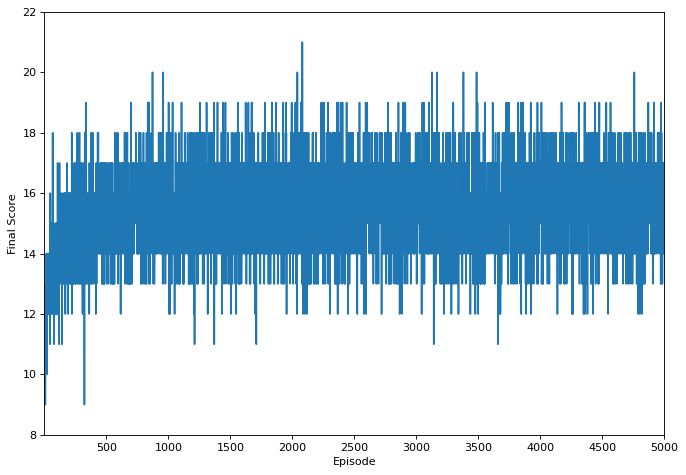

In [16]:
aux_plots.plot_scores(scores)

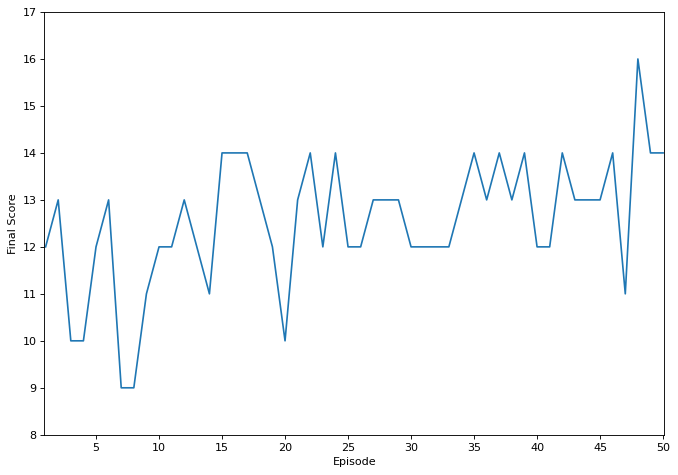

In [28]:
aux_plots.plot_scores(scores[0:50])

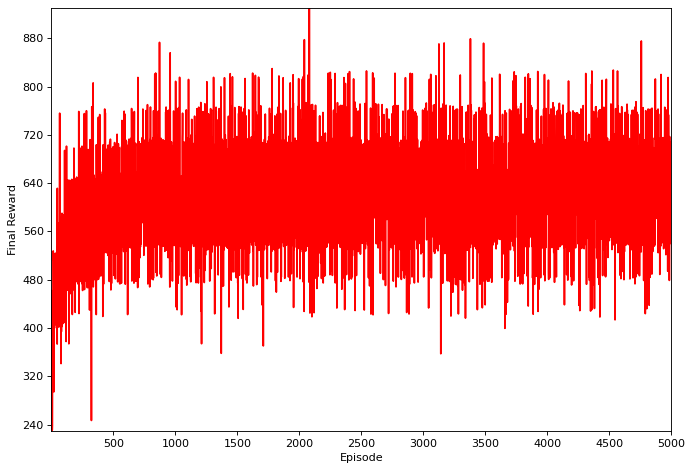

In [17]:
aux_plots.plot_rewards(total_rewards)

In [18]:
saveHistory("MontecarloAproximatorMeanFeaturesBias5000",scores,total_rewards)

Scores and Total rewards for MontecarloAproximatorMeanFeaturesBias5000 saved


In [22]:
cwd = os.getcwd()

In [23]:
modelSavePath=cwd+"/models/"

In [27]:
exp = serializer.Experiment(agent, scores, total_rewards, reduce_state, reward_policy)
exp.save_experiment(modelSavePath,'model_mc_approximator_'+"MeanFeaturesBias5000")
print("Model saved!")

Model saved!
